# Useful imports

In [66]:
from collections import namedtuple
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
import highway_env


# Collect experience
Randomly interact with the environment to produce a batch of experiences 
$$D = \{s_t, a_t, s_{t+1}\}_{t\in[1,N]}$$

In [67]:
Transition = namedtuple('Transition', ['state', 'action', 'next_state'])

def collect_interaction_data(env, size=100):
    data, done = [], True
    for _ in range(size):
        previous_obs = env.reset() if done else obs
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        data.append(Transition(torch.Tensor(previous_obs["observation"]),
                               torch.Tensor(action),
                               torch.Tensor(obs["observation"])))
    return data


env = gym.make("parking-v0")
data = collect_interaction_data(env, size=100)
print("Sample transition:", data[0])

Sample transition: Transition(state=tensor([ 0.0000,  0.0000, -0.0000, -0.0000, -0.0020, -0.0098]), action=tensor([-0.5833, -0.7930]), next_state=tensor([ 1.5726e-03,  1.3499e-02,  2.6930e-04,  2.9162e-02, -9.2345e-05,
        -9.9996e-03]))


# Build dynamics model

In [68]:
class DynamicsModel(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super().__init__()
        self.state_size, self.action_size = state_size, action_size
        A_size, B_size = state_size * state_size, state_size * action_size
        self.A1 = nn.Linear(state_size + action_size, hidden_size)
        self.A2 = nn.Linear(hidden_size, A_size)
        self.B1 = nn.Linear(state_size + action_size, hidden_size)
        self.B2 = nn.Linear(hidden_size, B_size)

    def forward(self, x, u, dt=1.0):
        if len(x.shape) == 1:
            x = x.unsqueeze(0)
            u = u.unsqueeze(0)
        xu = torch.cat((x, u), -1)
        A = self.A2(F.relu(self.A1(xu)))
        A = torch.reshape(A, (x.shape[0], self.state_size, self.state_size))
        B = self.B2(F.relu(self.B1(xu)))
        B = torch.reshape(B, (x.shape[0], self.state_size, self.action_size))
        dx = A @ x.unsqueeze(-1) + B @ u.unsqueeze(-1)
        return x + dx.squeeze() * dt


dynamics = DynamicsModel(env.observation_space.spaces["observation"].shape[0],
                         env.action_space.shape[0],
                         10)
print("Forward model on sample transition:", dynamics(data[0].state, data[0].action))

Forward model on sample transition: tensor([[ 0.2121,  0.5423, -0.1717, -0.3695,  0.0391,  0.1580]],
       grad_fn=<AddBackward0>)


# Visualization helper

In [ ]:
def visualize(states, actions, next_states, predictions):
    plt.cla()
    dx = next_states.data.numpy() - states.data.numpy()
    pred_dx = predictions.data.numpy() - states.data.numpy()
    a = actions.data.numpy()
    plt.scatter(a[:, 0], dx[:, 2], )
    plt.scatter(a[:, 0], pred_dx[:, 2])
    plt.pause(0.1)

# Fit model on data

Loss [2/1000]: 0.0009601940982975066
Loss [3/1000]: 0.0009598633041605353
Loss [4/1000]: 0.0009595330921001732
Loss [5/1000]: 0.0009592035785317421
Loss [6/1000]: 0.0009588747634552419
Loss [7/1000]: 0.0009585465886630118
Loss [8/1000]: 0.0009582191123627126
Loss [9/1000]: 0.0009578922181390226
Loss [10/1000]: 0.0009575660224072635
Loss [11/1000]: 0.0009572405251674354
Loss [12/1000]: 0.0009569156100042164
Loss [13/1000]: 0.0009565913933329284
Loss [14/1000]: 0.0009562677587382495
Loss [15/1000]: 0.0009559448226355016
Loss [16/1000]: 0.0009556225268170238
Loss [17/1000]: 0.0009553012787364423
Loss [18/1000]: 0.0009549816022627056
Loss [19/1000]: 0.000954662449657917
Loss [20/1000]: 0.0009543439955450594
Loss [21/1000]: 0.000954026123508811
Loss [22/1000]: 0.0009537088917568326
Loss [23/1000]: 0.0009533923002891243
Loss [24/1000]: 0.000953076349105686
Loss [25/1000]: 0.0009527609799988568
Loss [26/1000]: 0.0009524462511762977
Loss [27/1000]: 0.0009521321044303477
Loss [28/1000]: 0.00095

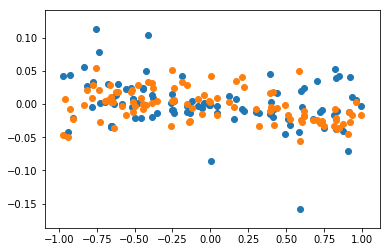

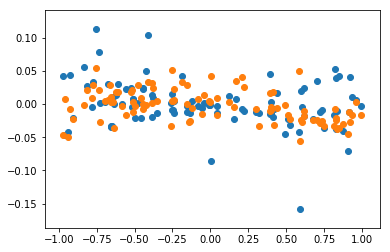

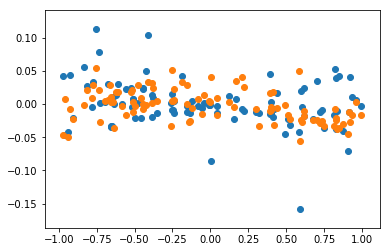

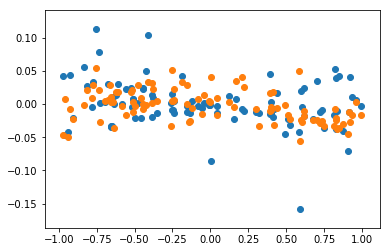

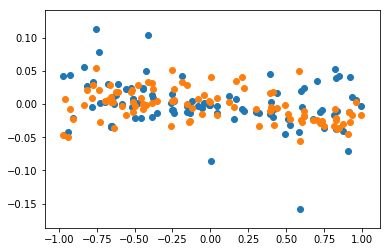

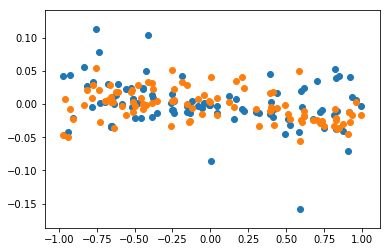

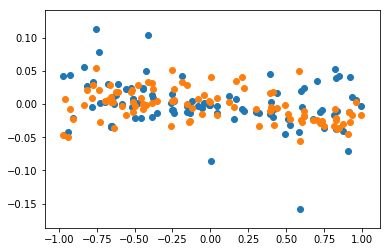

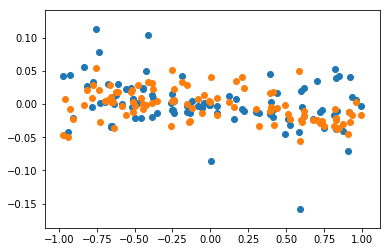

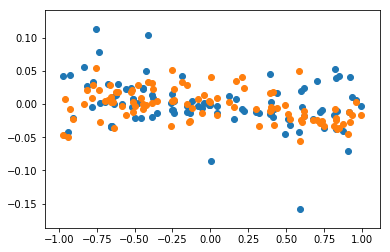

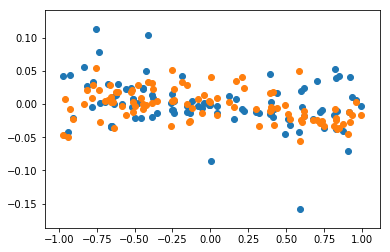

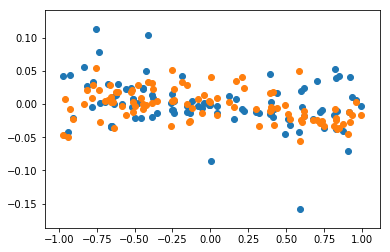

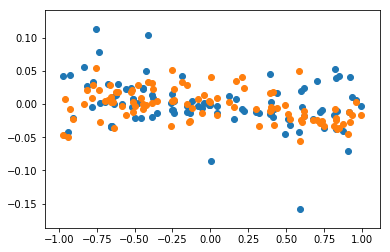

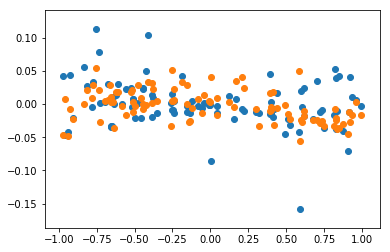

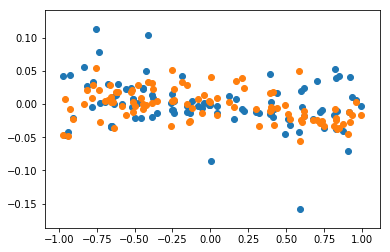

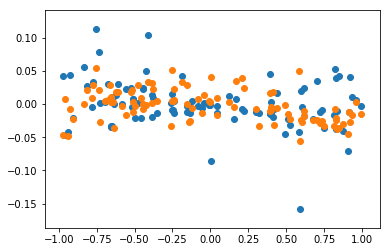

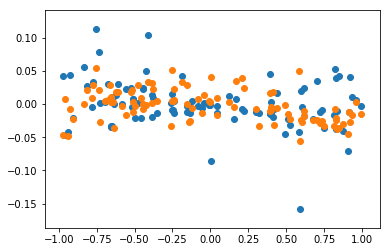

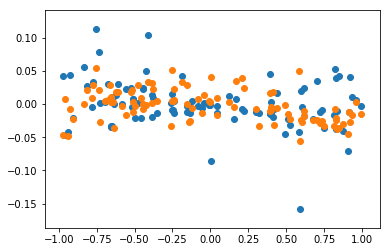

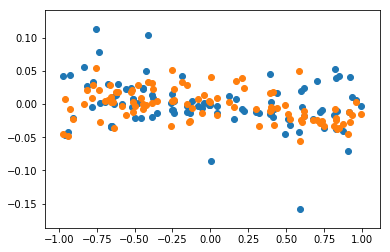

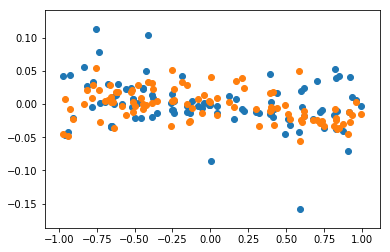

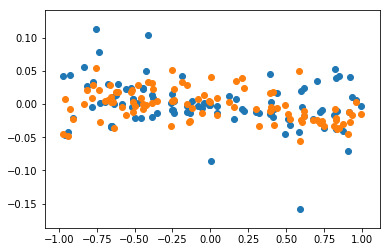

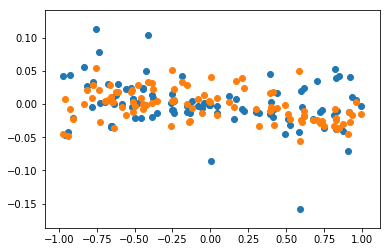

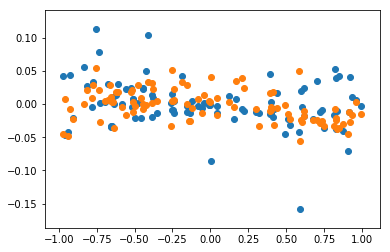

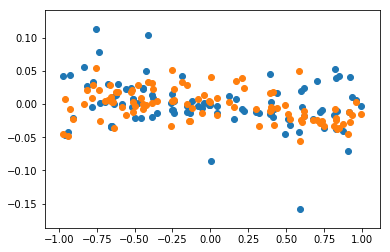

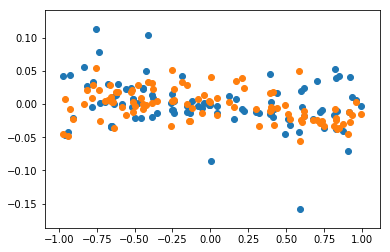

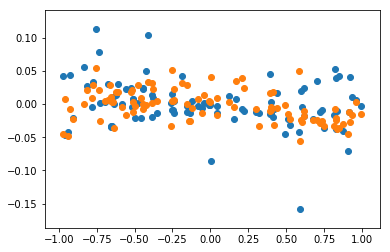

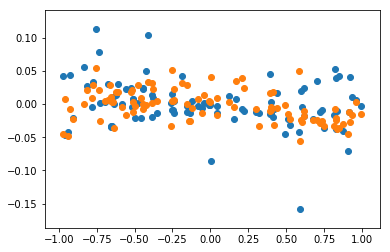

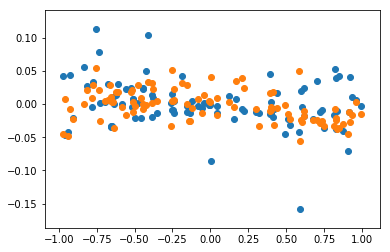

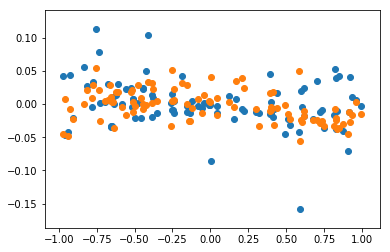

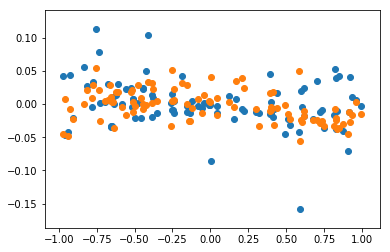

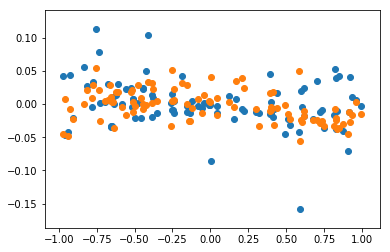

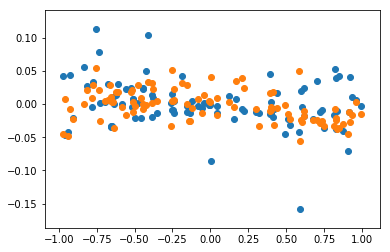

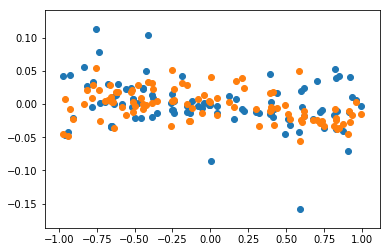

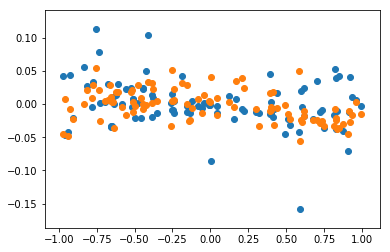

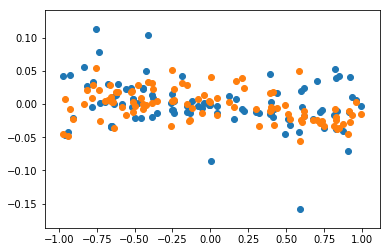

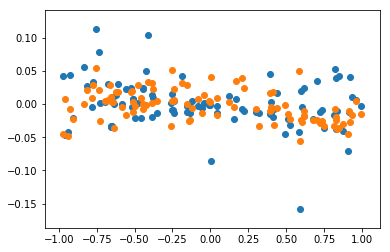

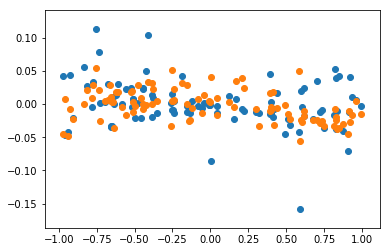

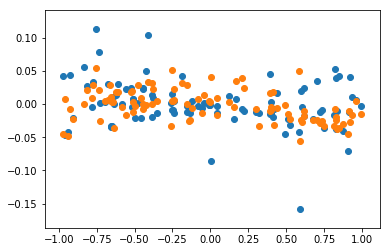

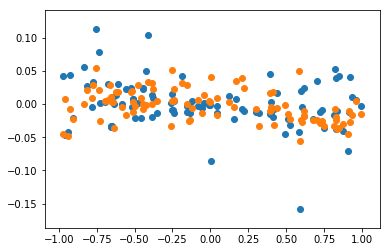

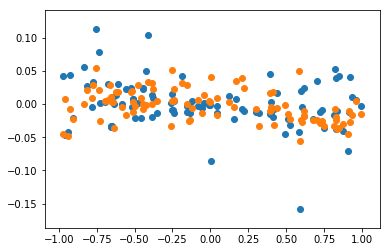

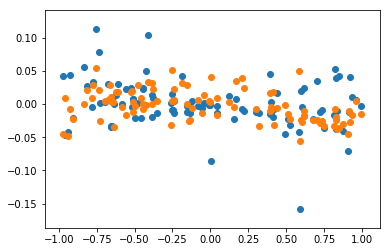

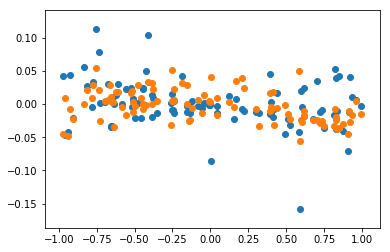

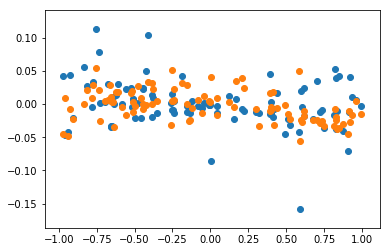

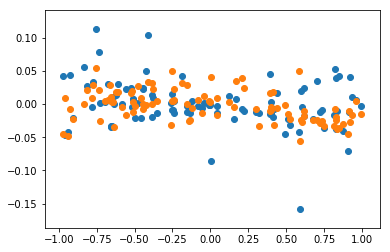

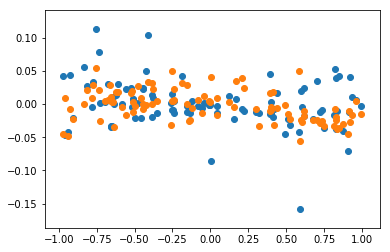

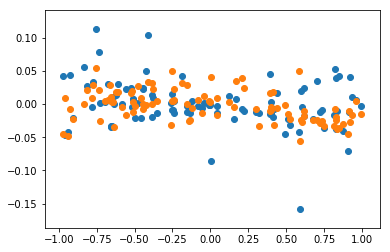

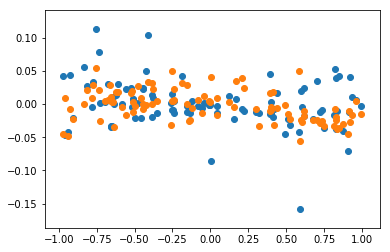

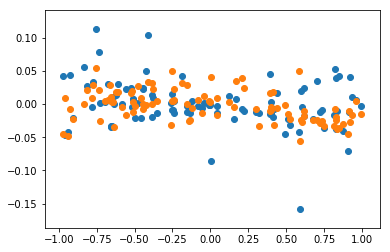

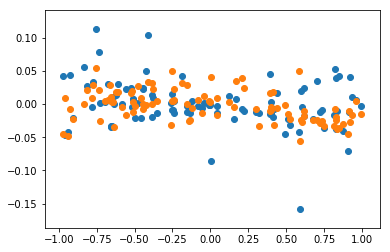

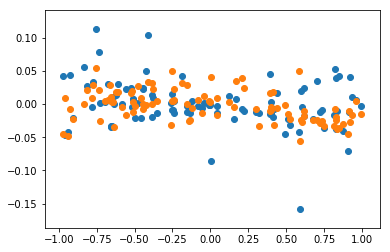

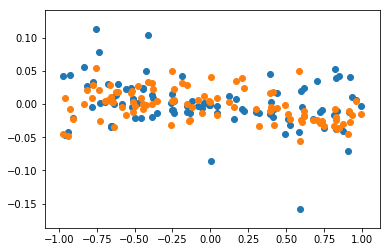

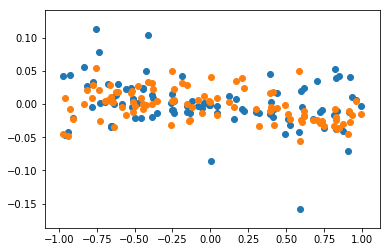

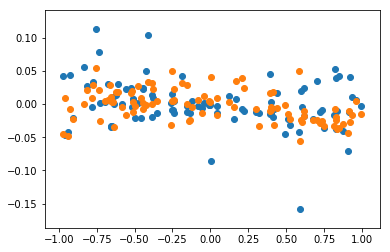

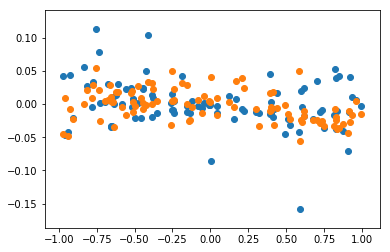

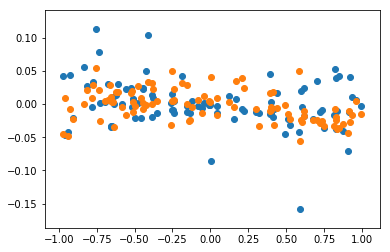

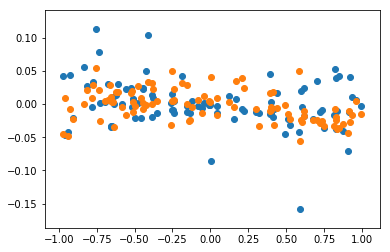

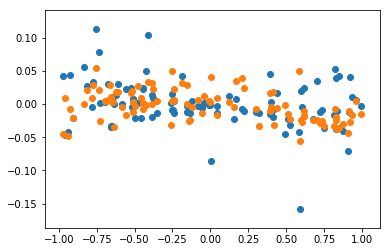

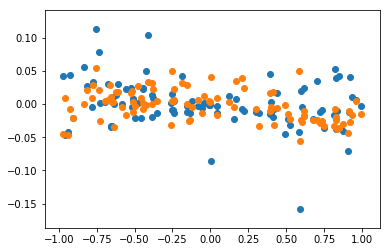

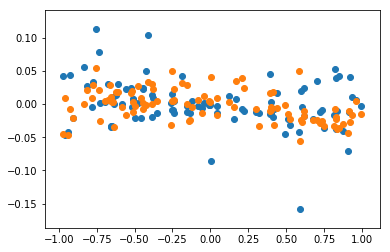

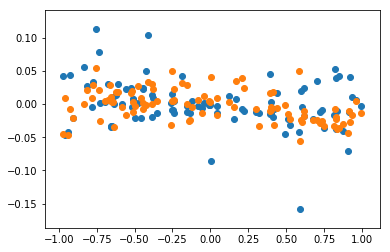

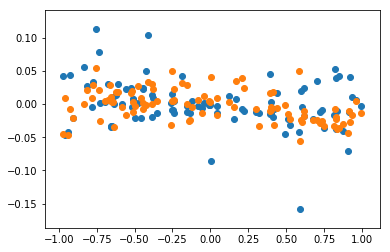

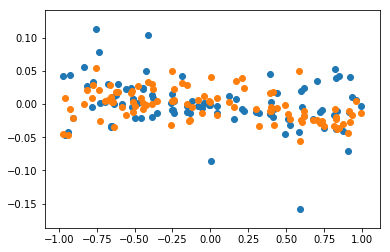

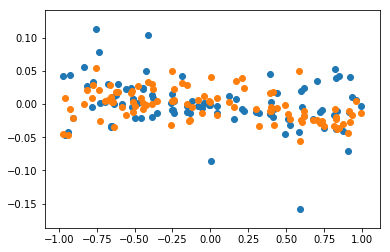

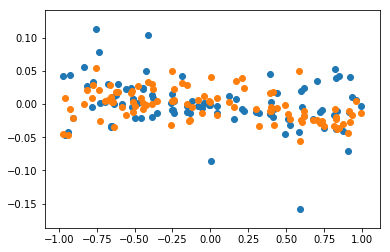

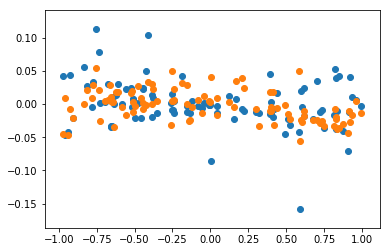

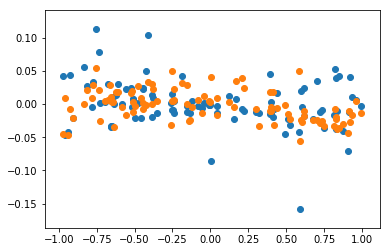

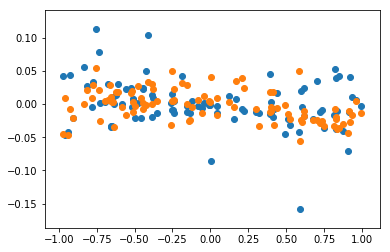

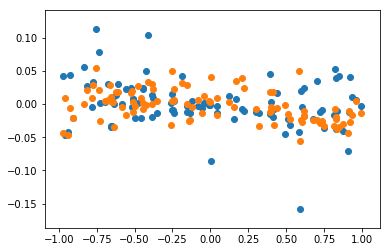

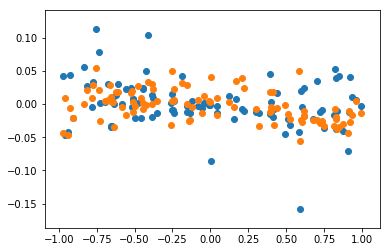

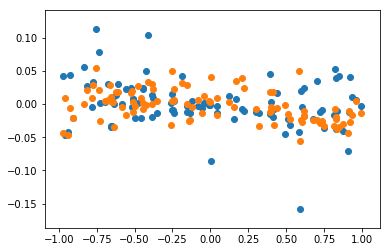

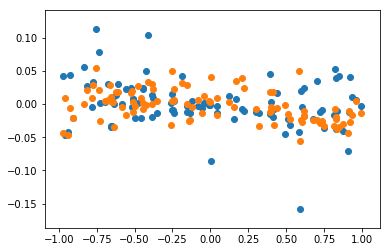

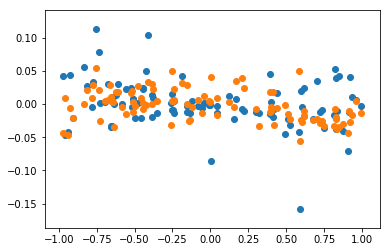

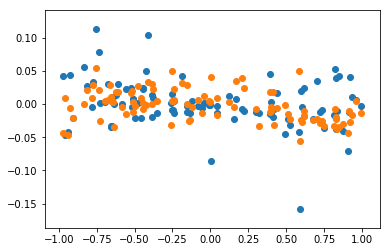

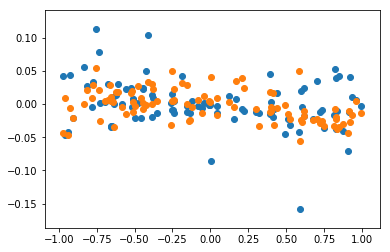

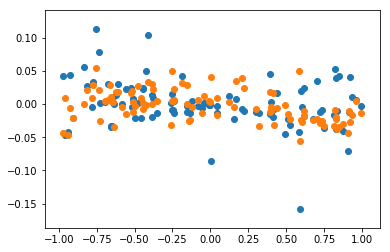

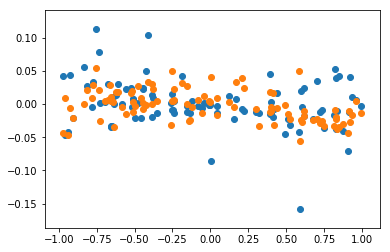

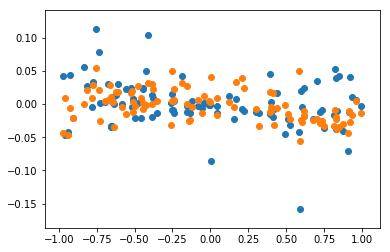

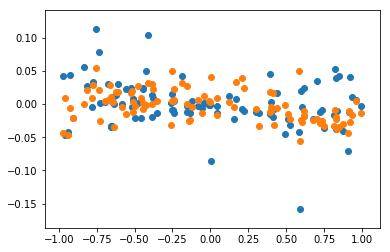

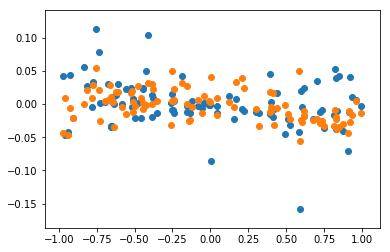

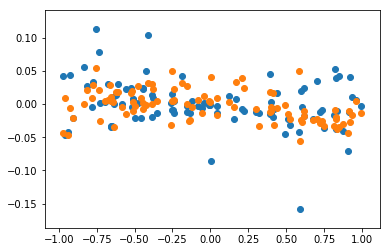

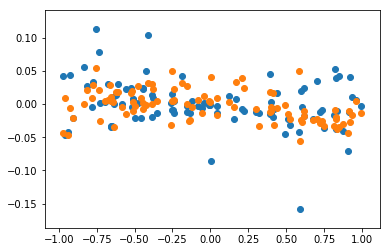

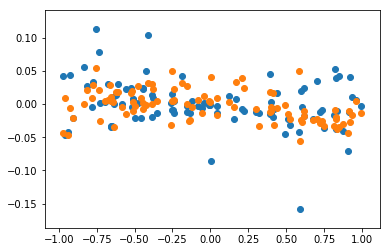

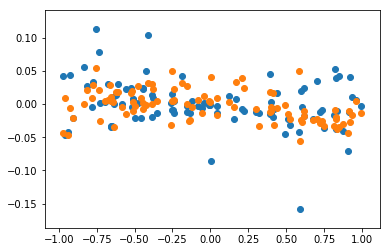

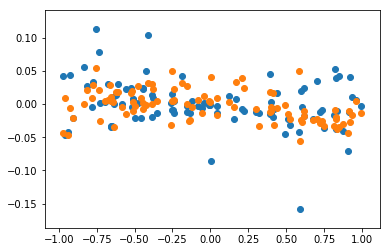

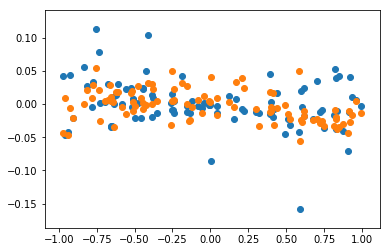

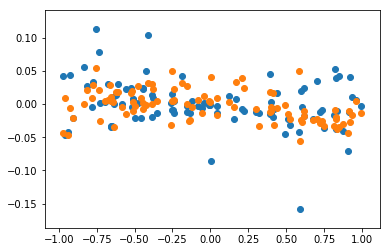

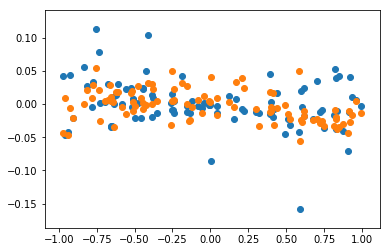

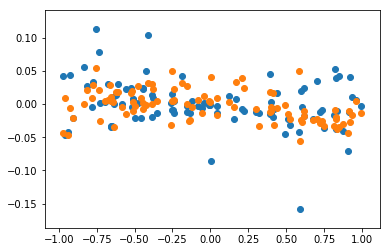

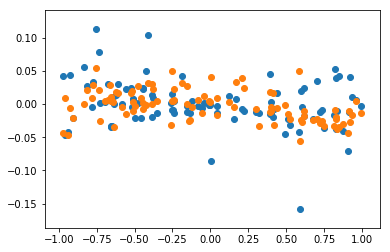

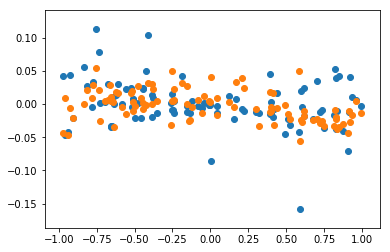

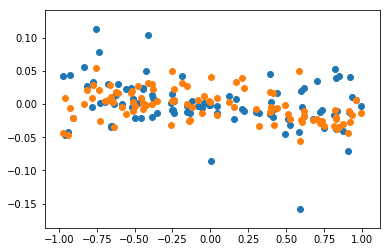

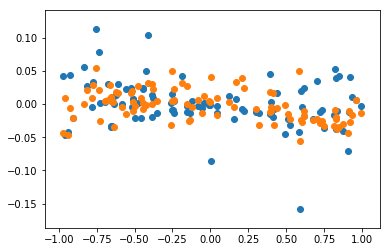

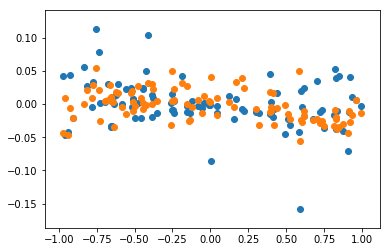

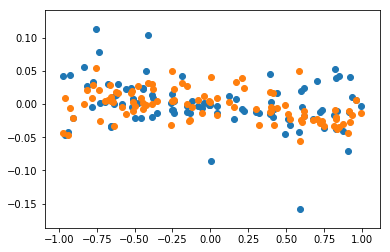

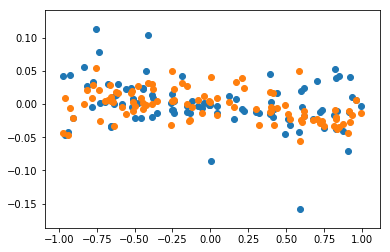

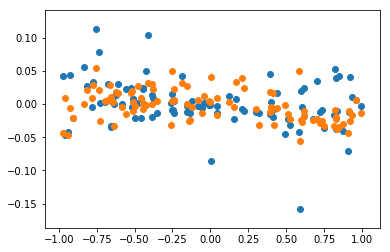

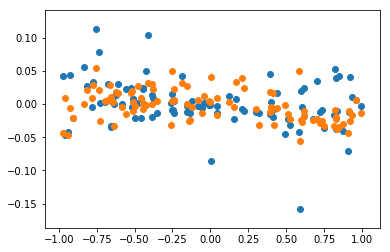

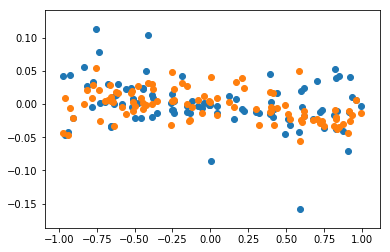

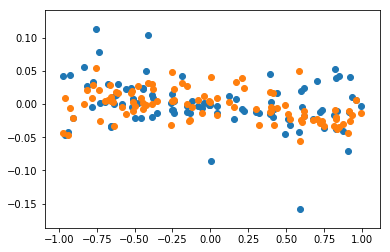

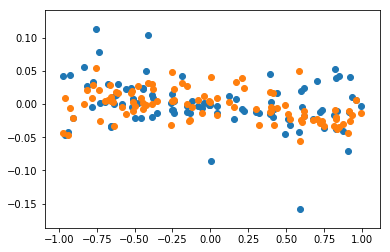

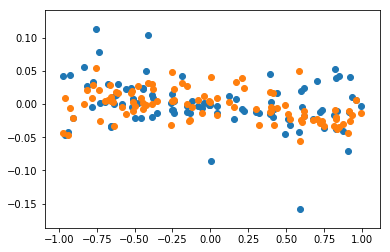

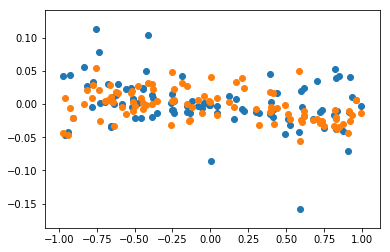

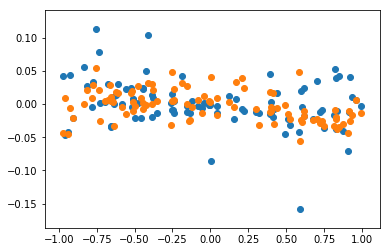

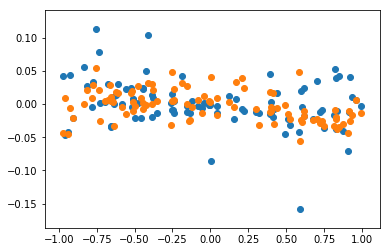

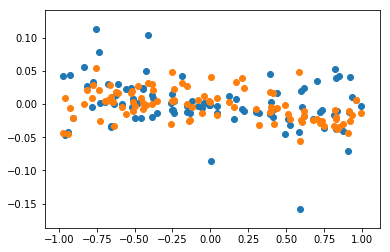

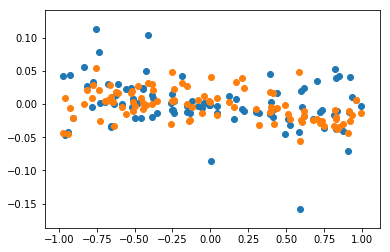

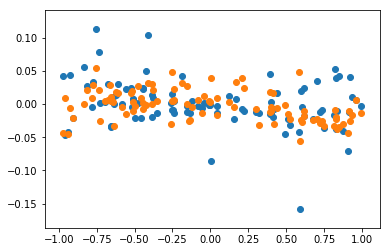

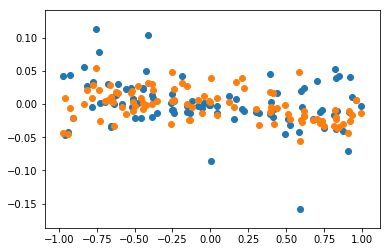

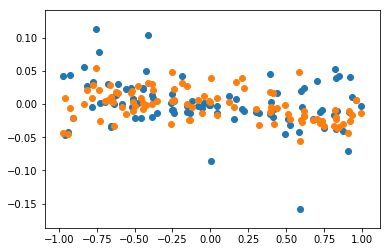

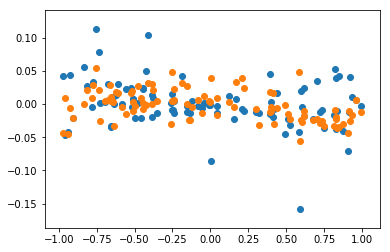

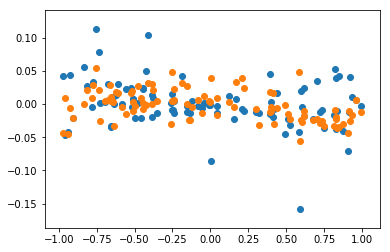

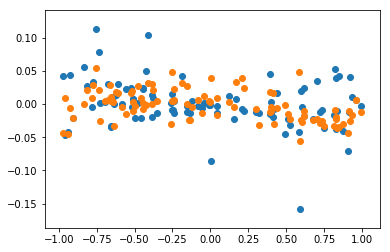

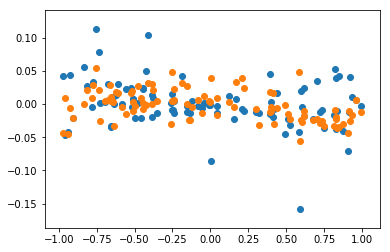

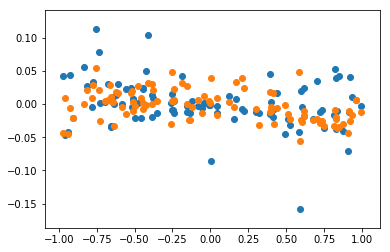

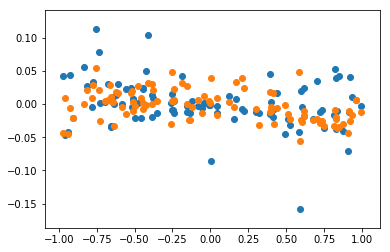

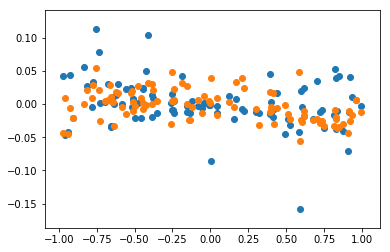

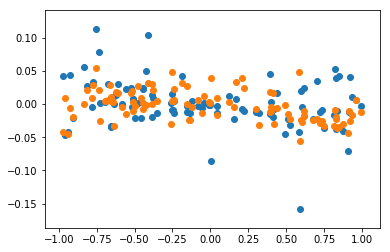

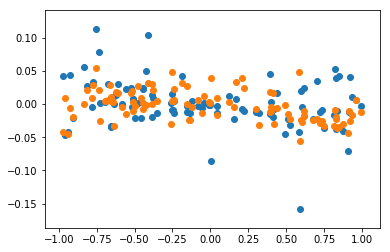

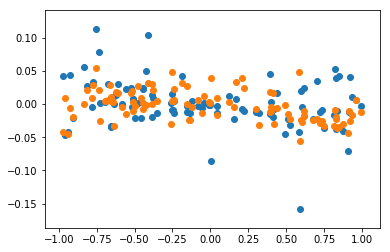

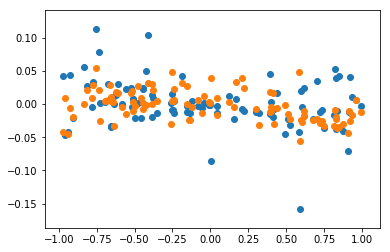

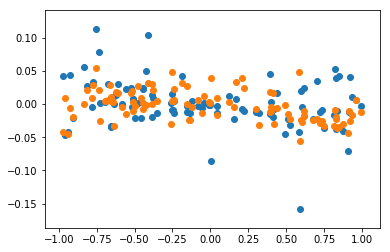

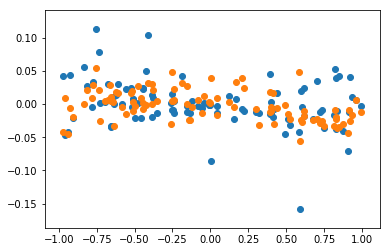

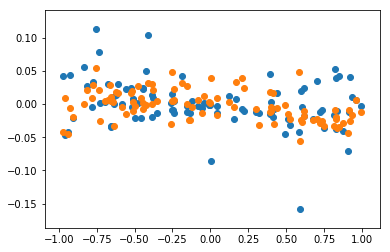

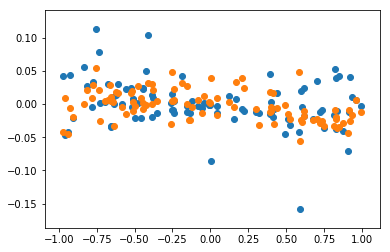

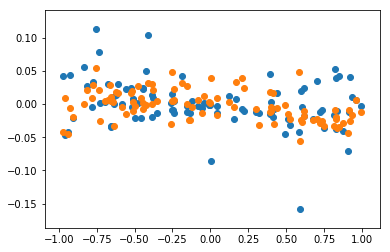

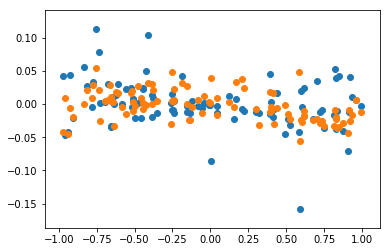

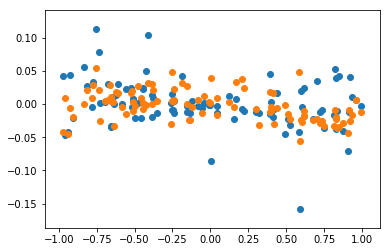

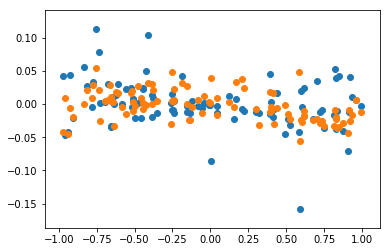

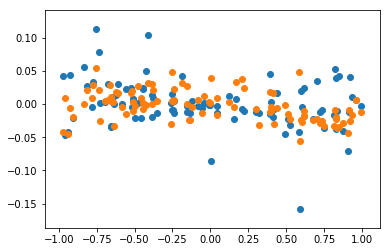

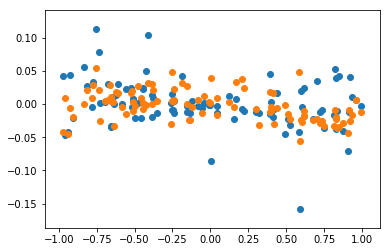

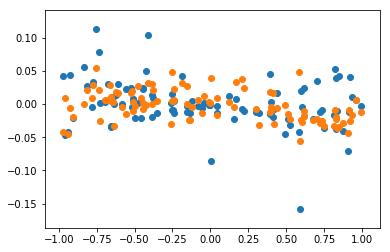

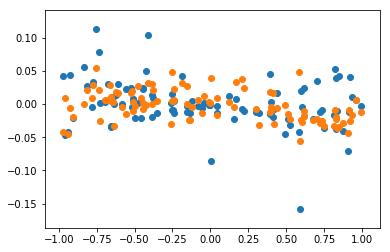

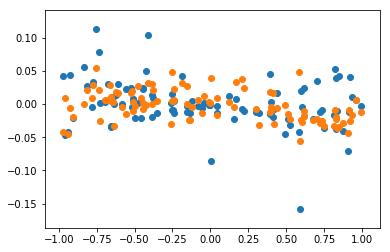

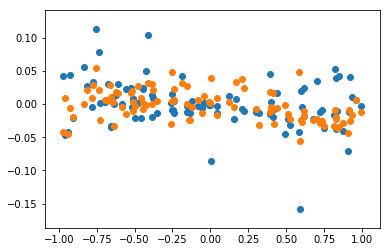

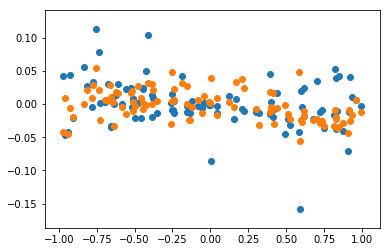

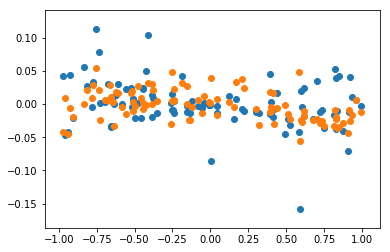

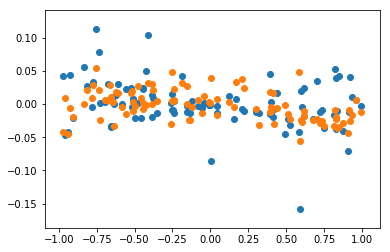

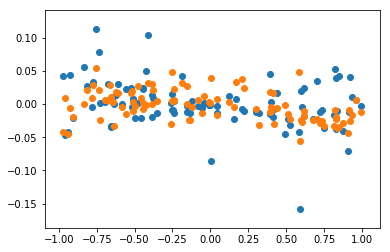

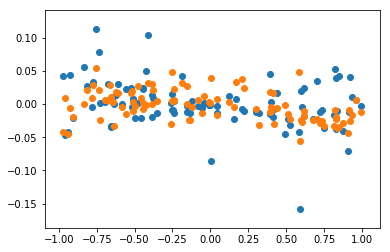

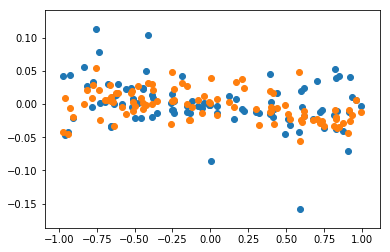

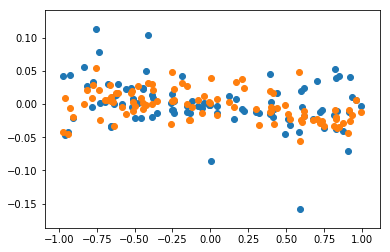

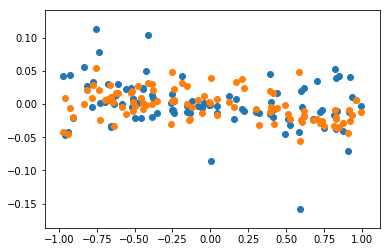

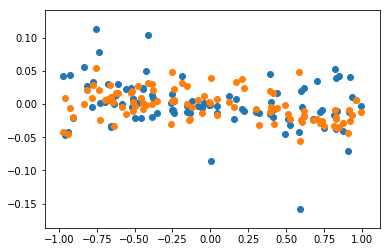

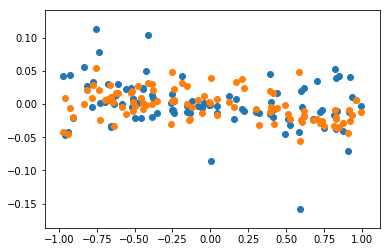

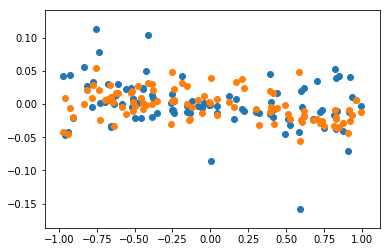

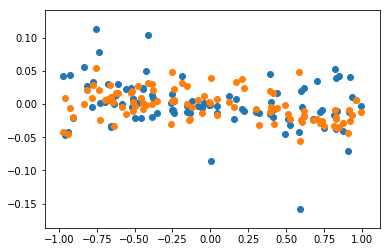

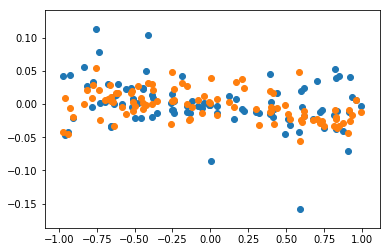

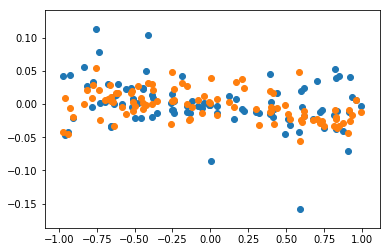

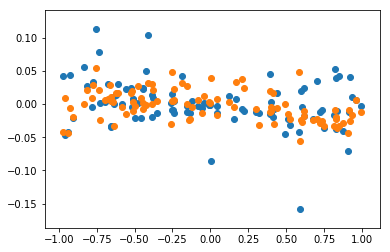

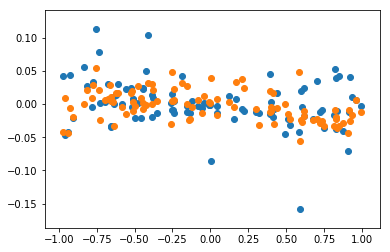

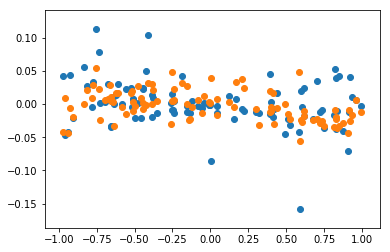

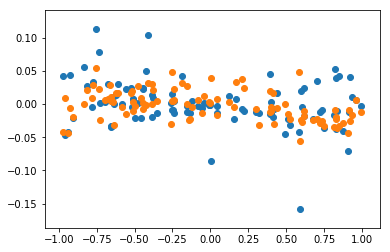

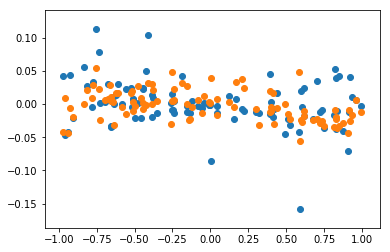

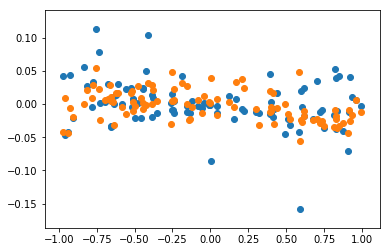

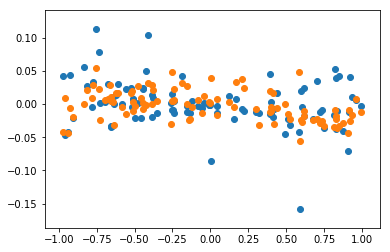

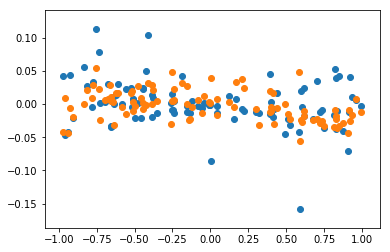

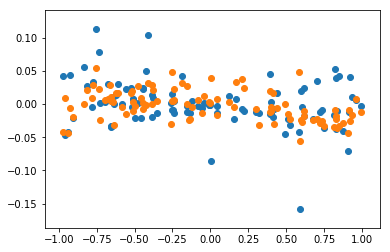

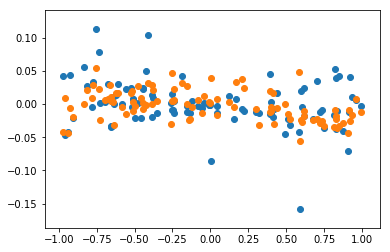

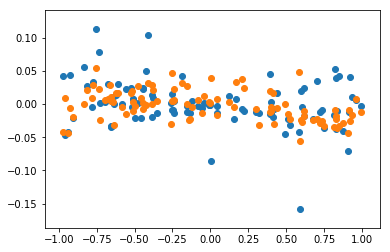

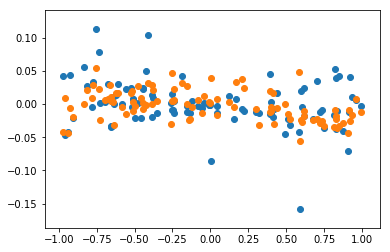

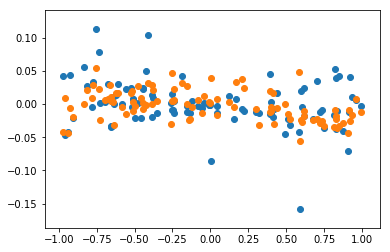

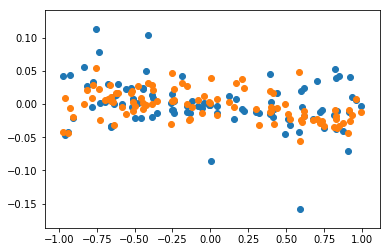

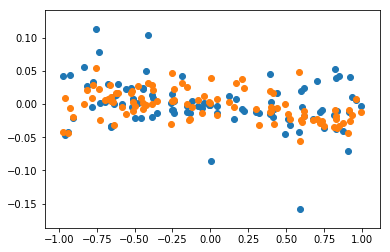

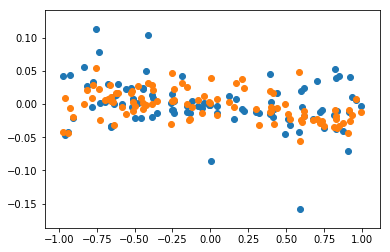

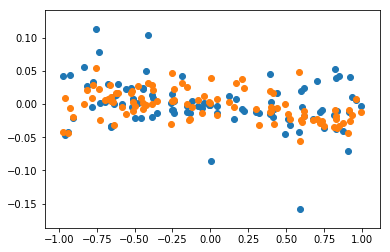

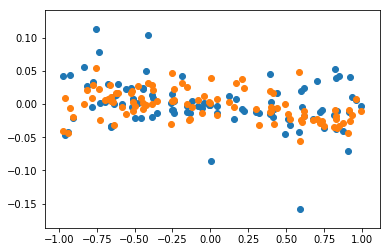

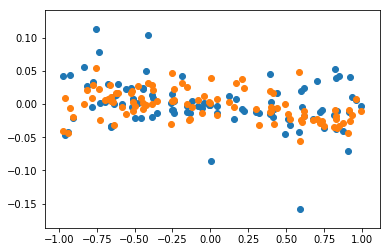

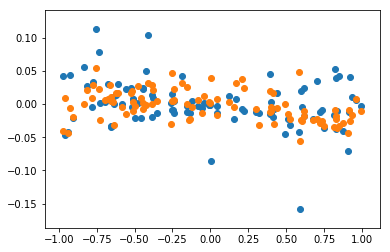

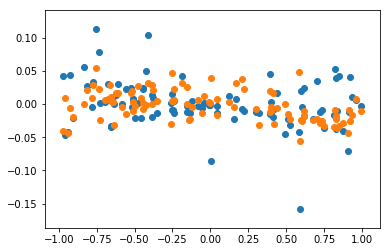

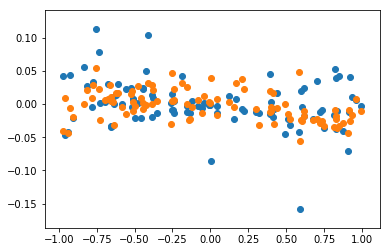

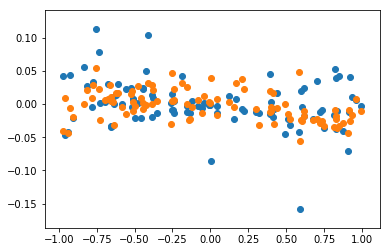

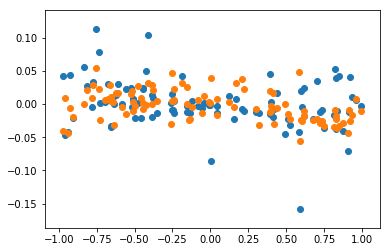

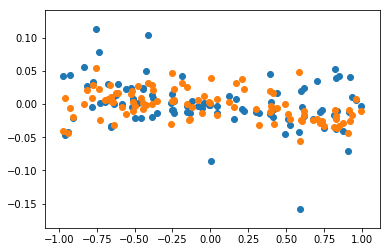

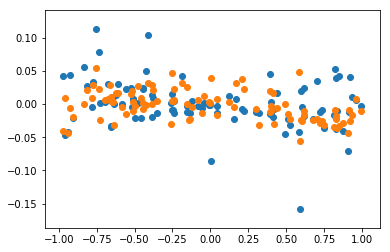

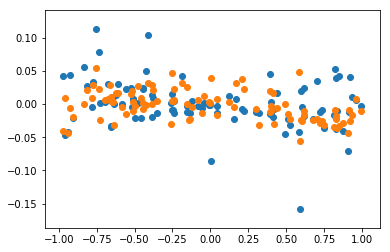

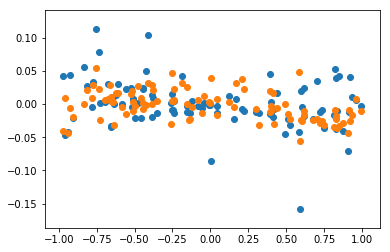

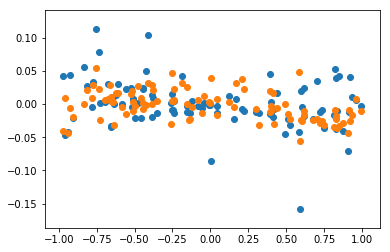

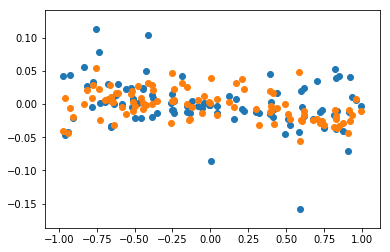

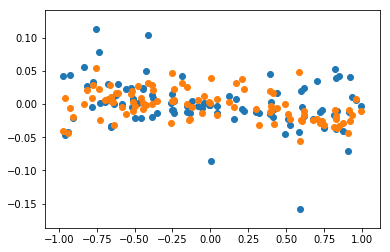

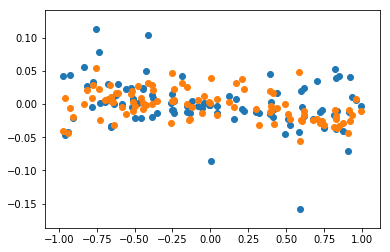

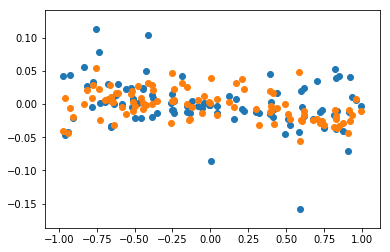

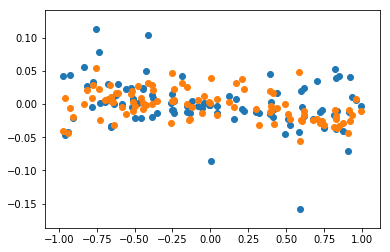

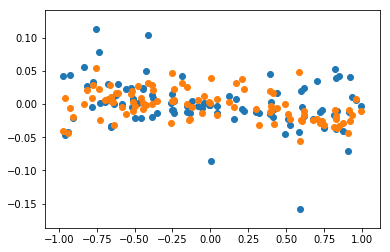

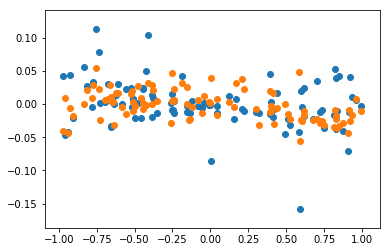

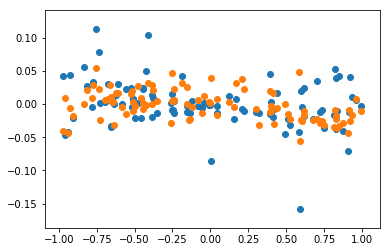

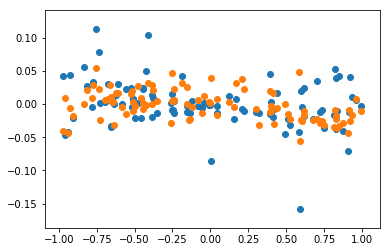

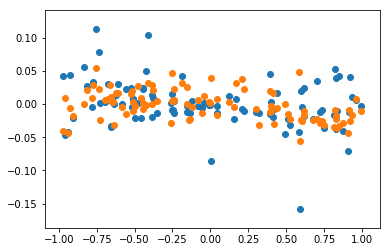

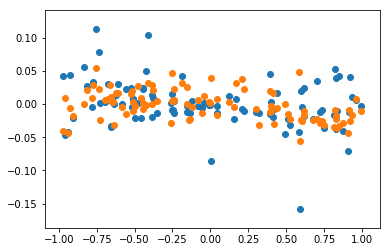

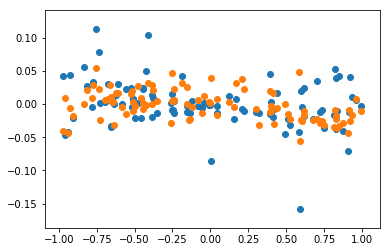

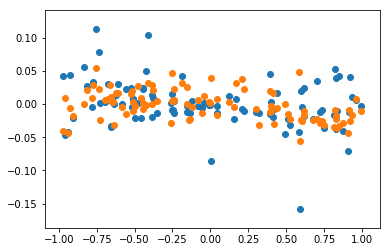

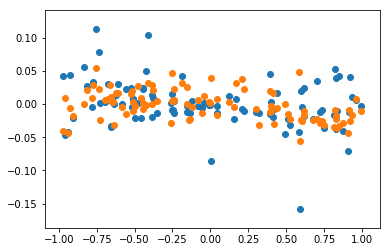

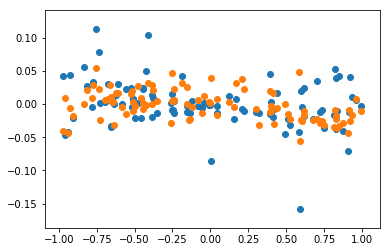

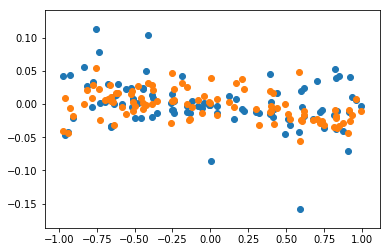

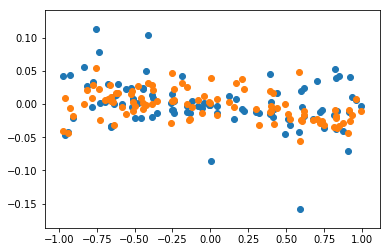

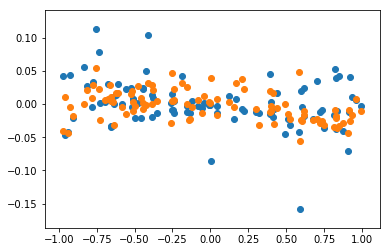

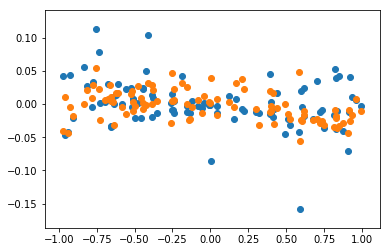

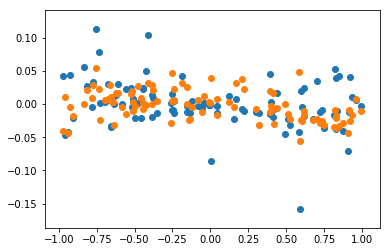

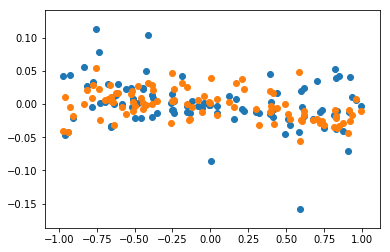

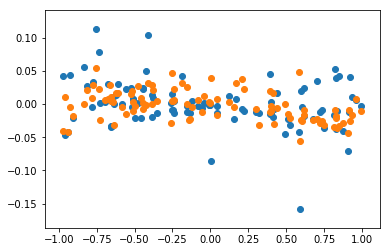

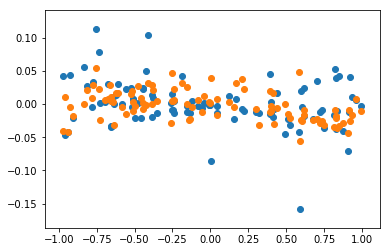

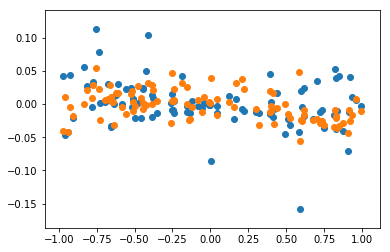

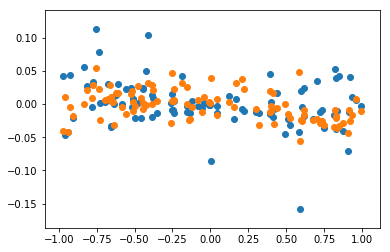

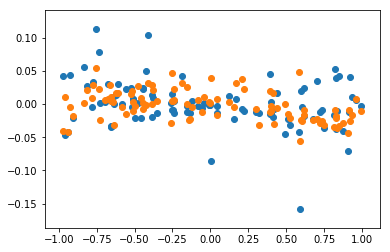

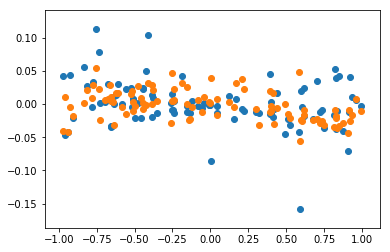

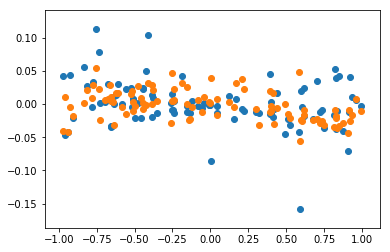

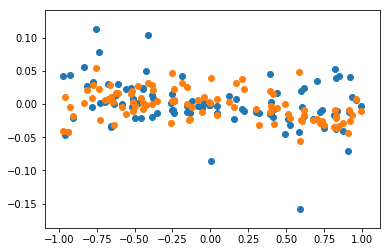

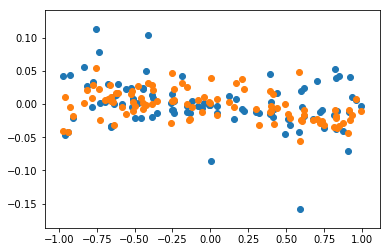

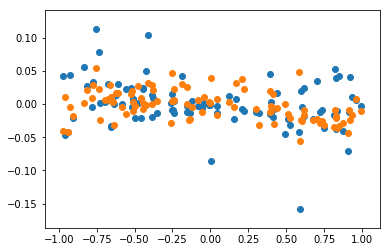

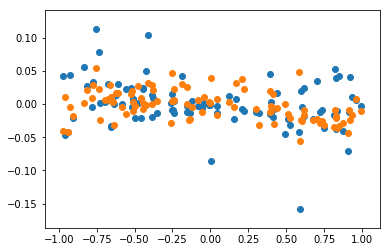

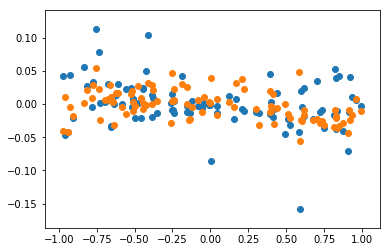

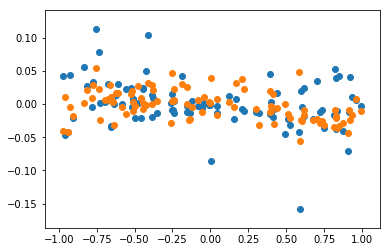

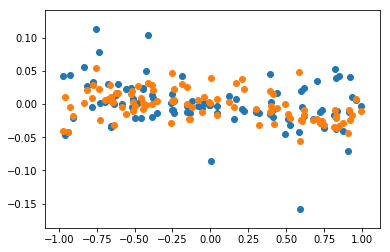

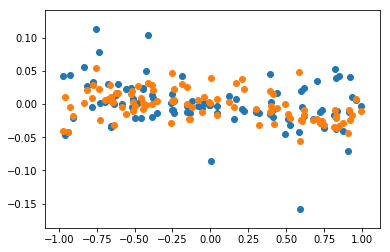

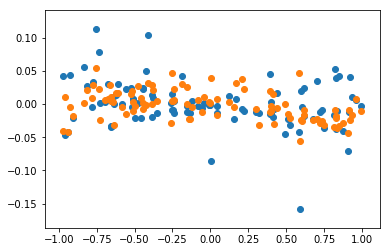

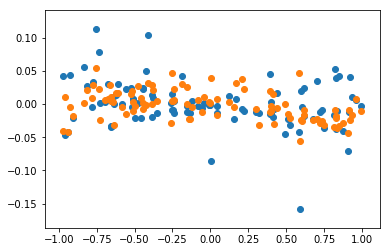

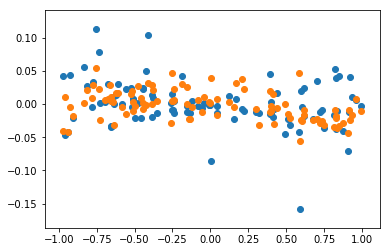

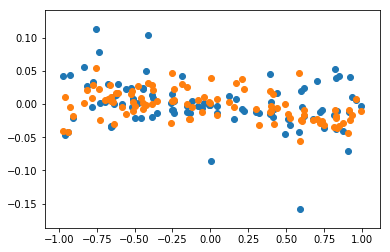

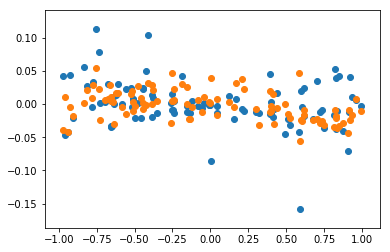

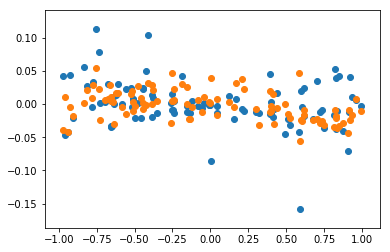

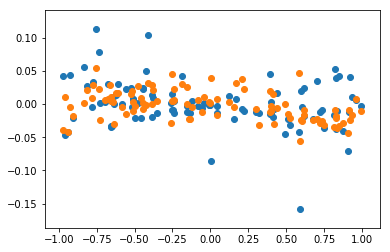

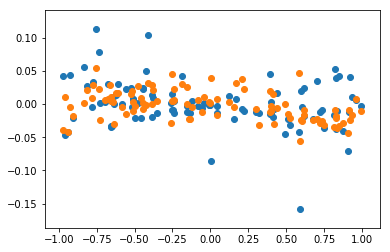

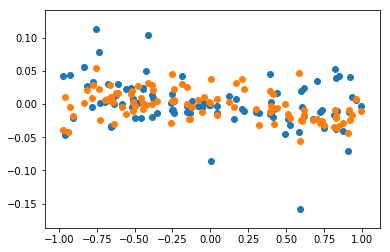

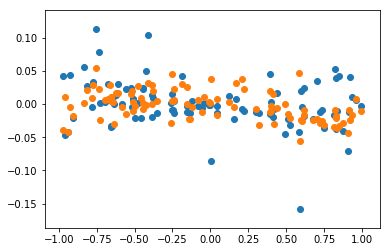

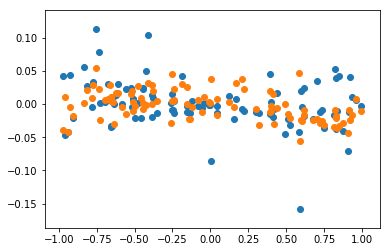

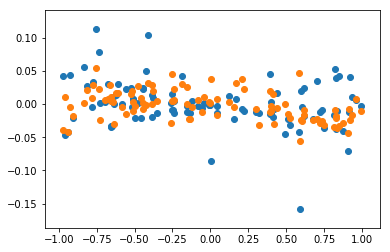

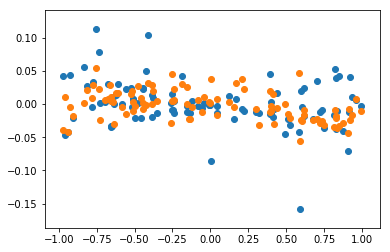

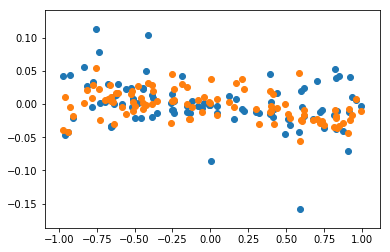

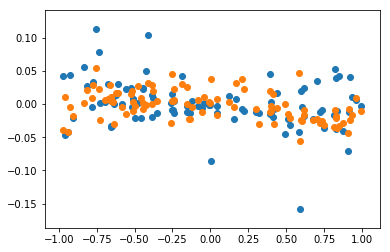

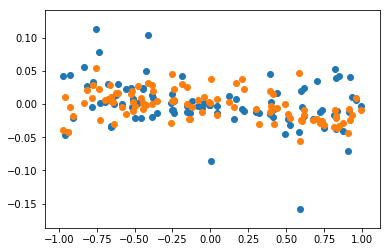

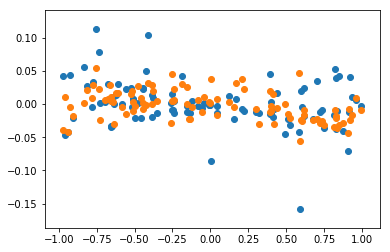

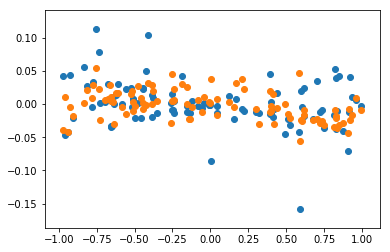

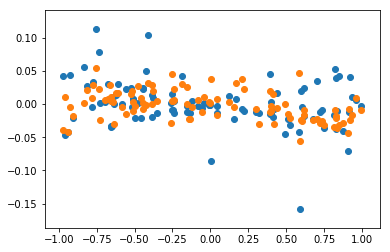

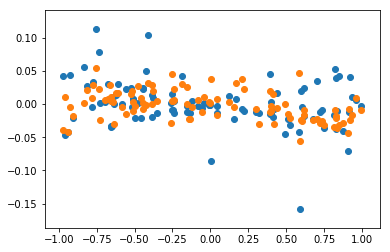

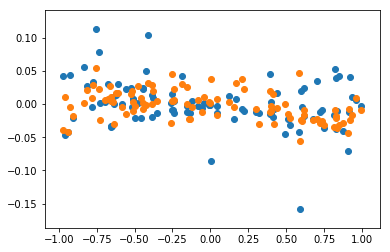

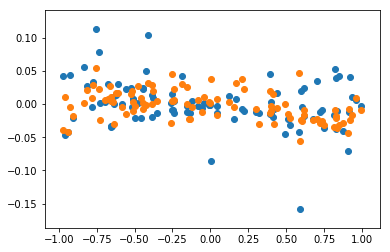

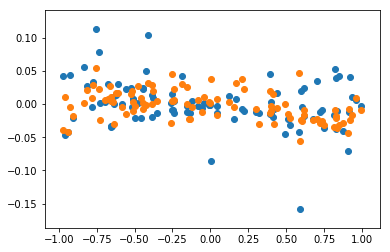

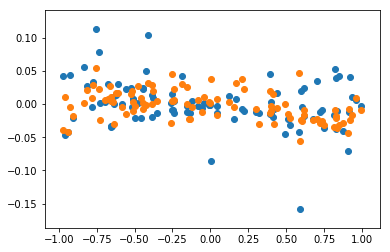

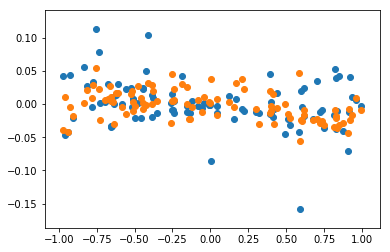

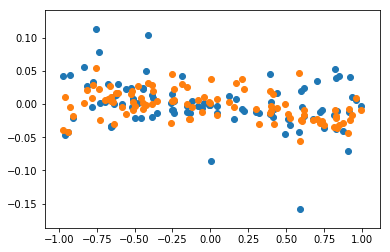

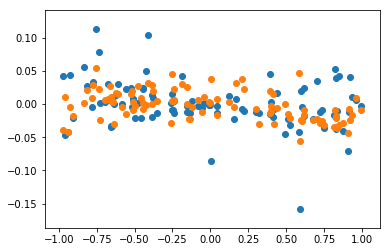

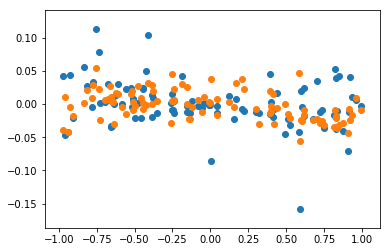

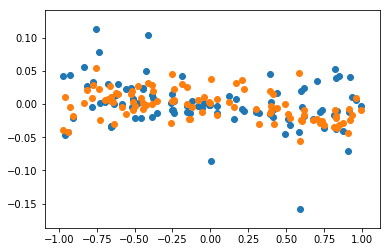

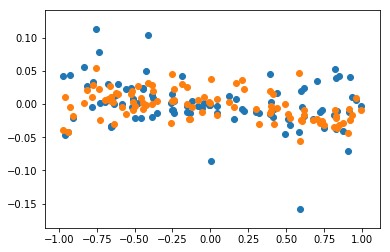

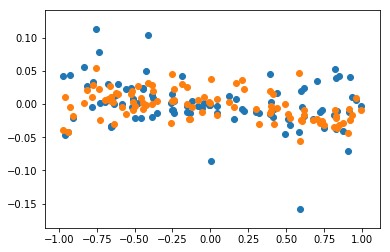

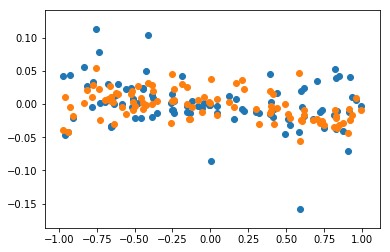

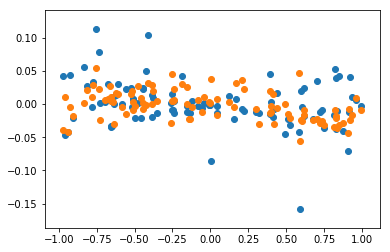

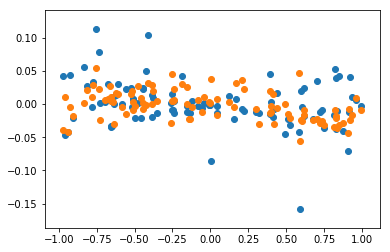

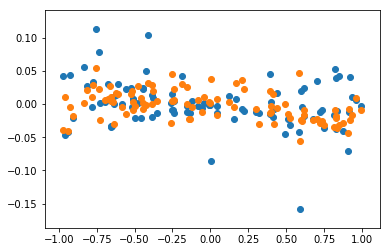

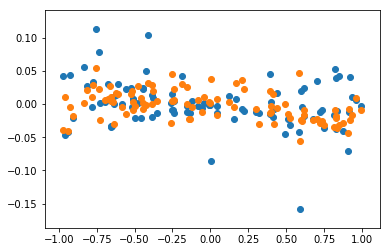

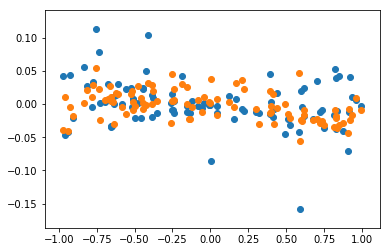

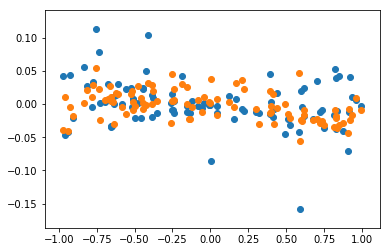

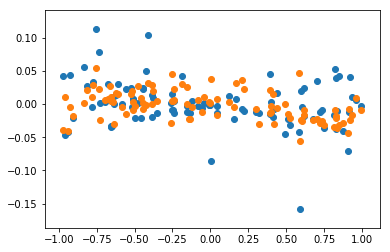

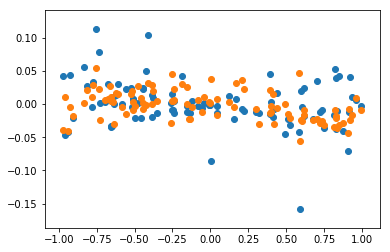

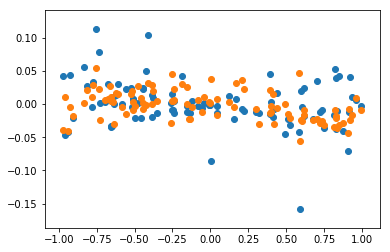

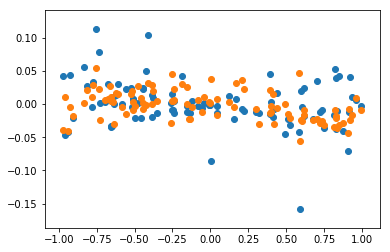

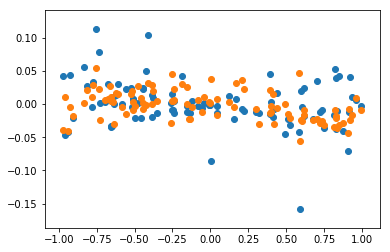

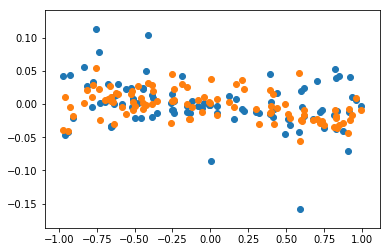

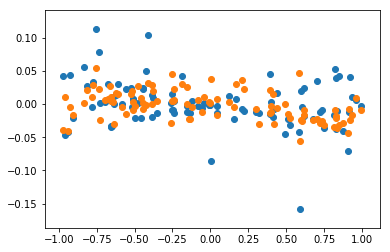

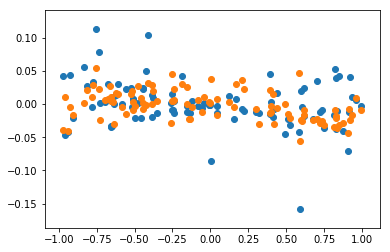

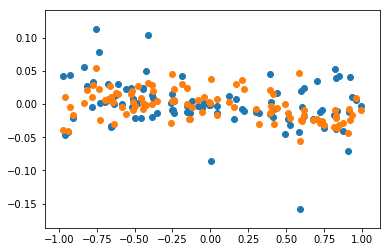

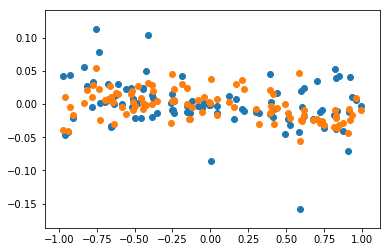

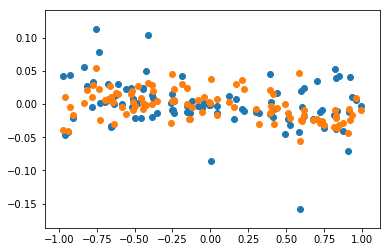

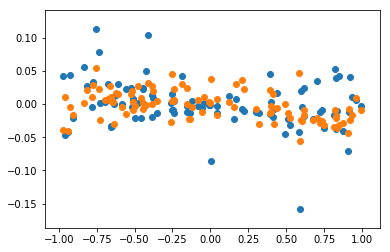

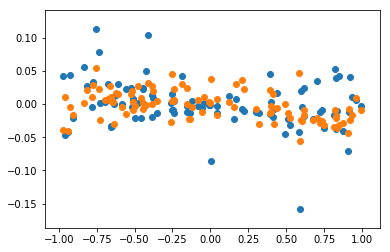

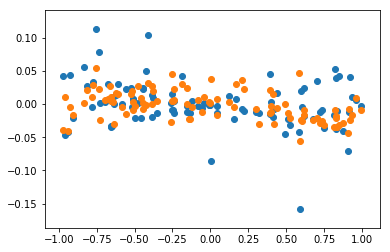

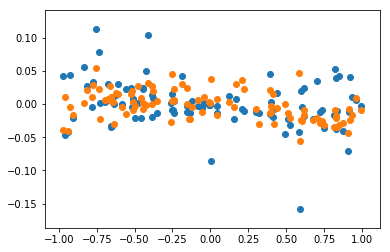

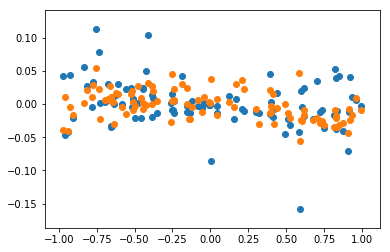

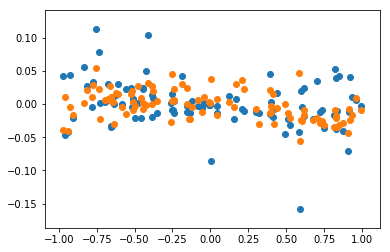

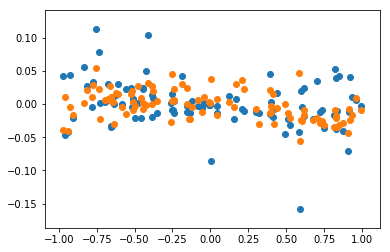

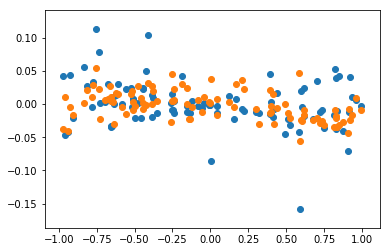

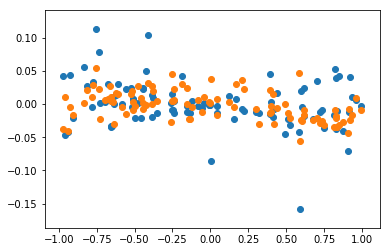

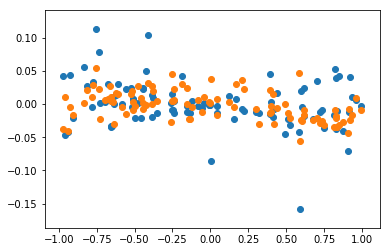

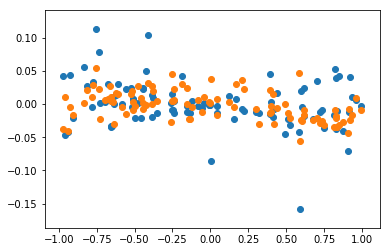

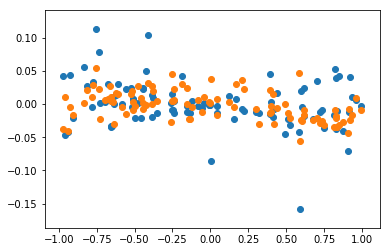

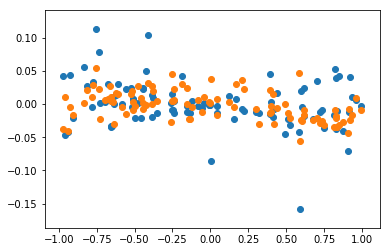

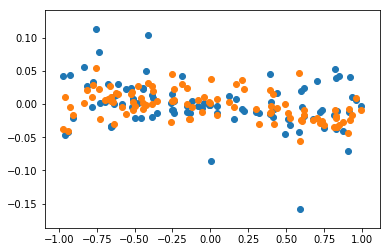

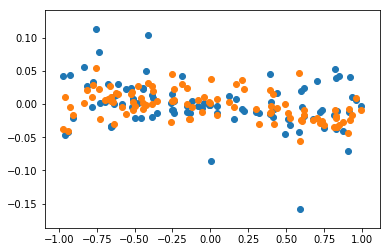

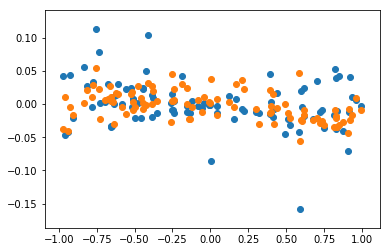

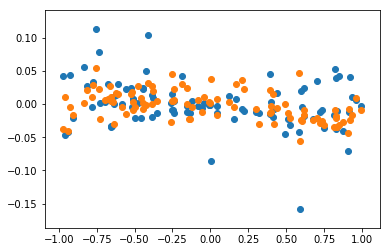

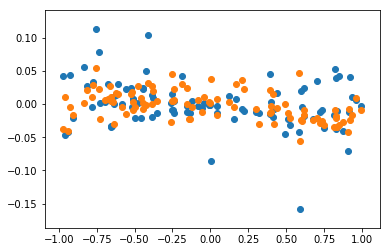

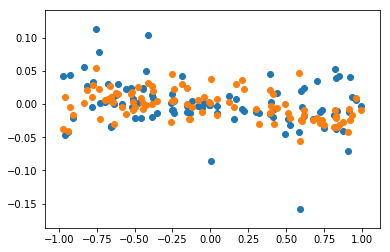

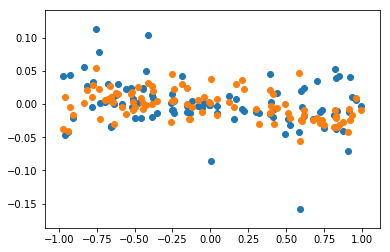

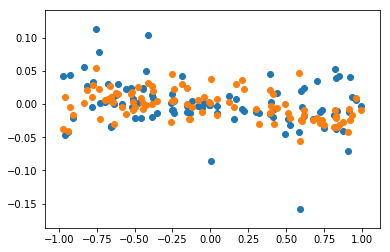

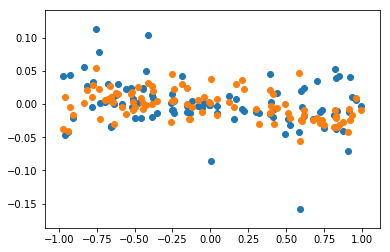

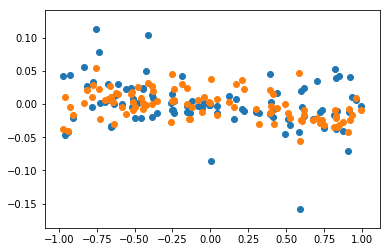

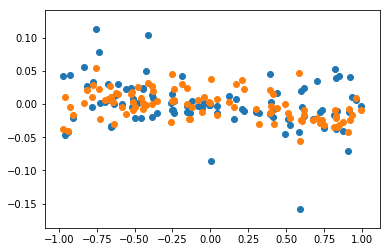

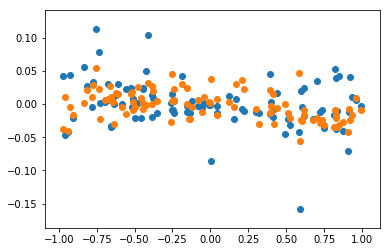

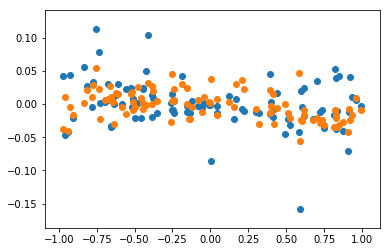

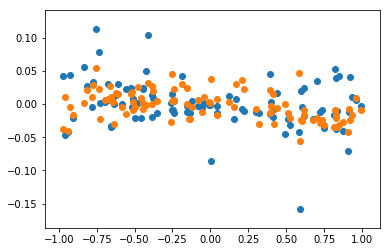

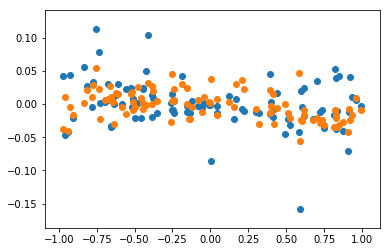

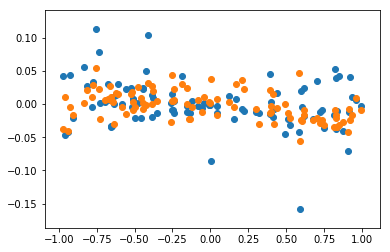

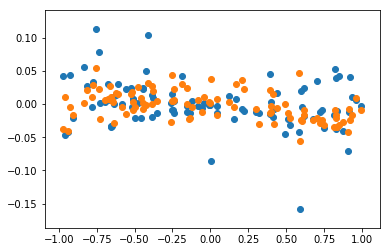

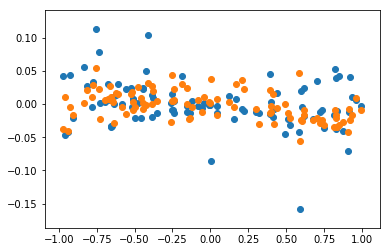

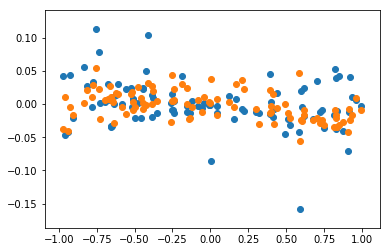

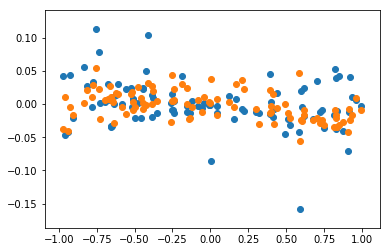

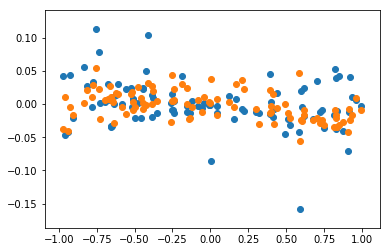

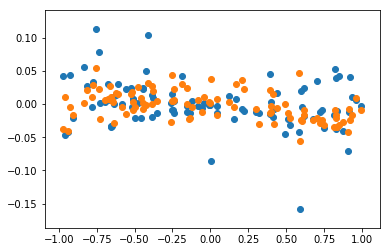

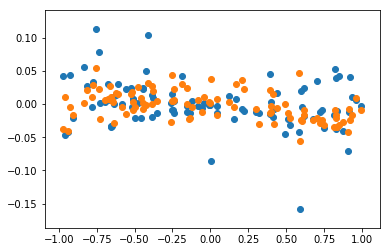

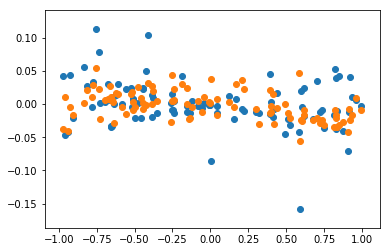

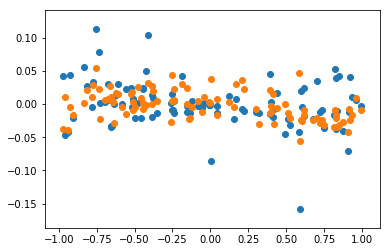

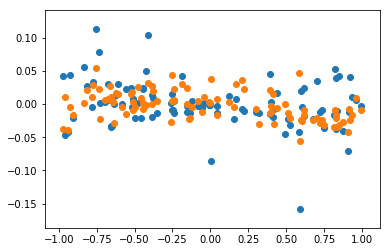

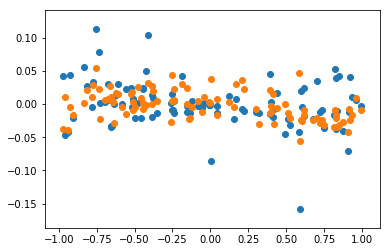

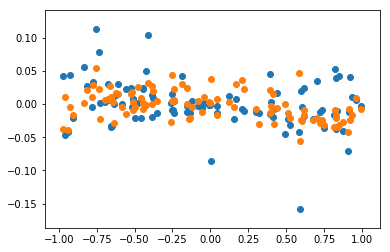

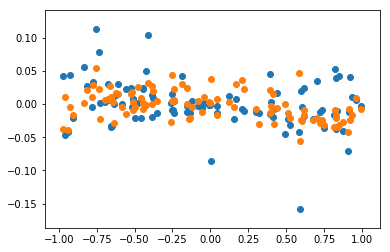

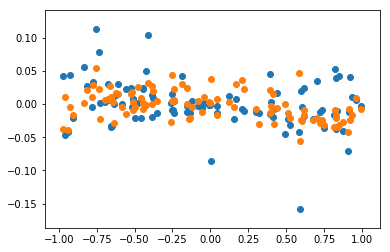

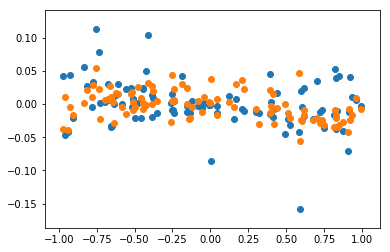

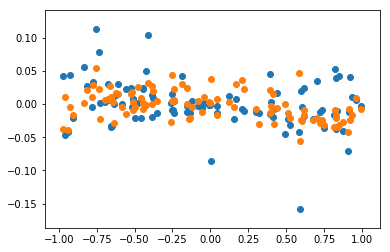

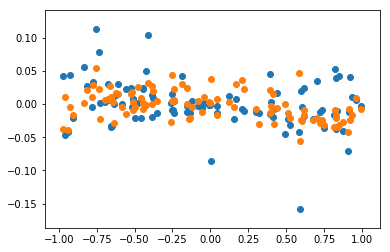

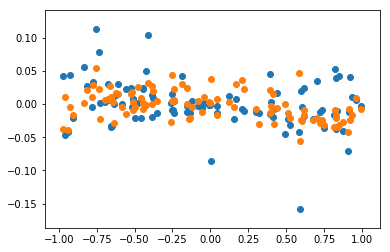

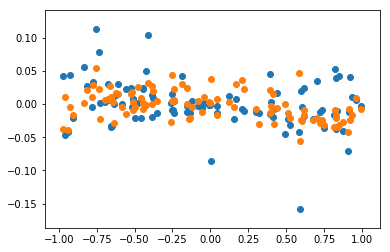

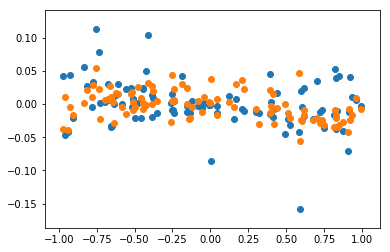

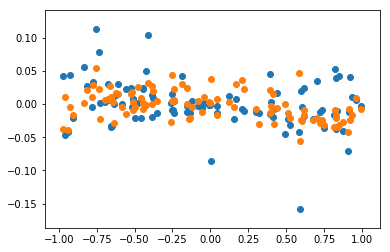

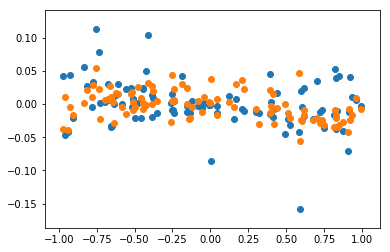

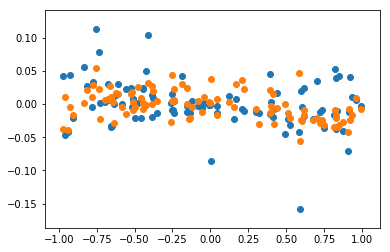

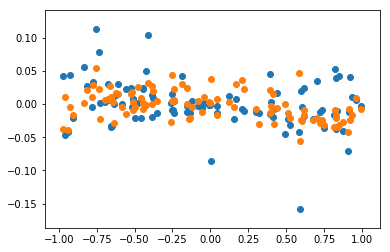

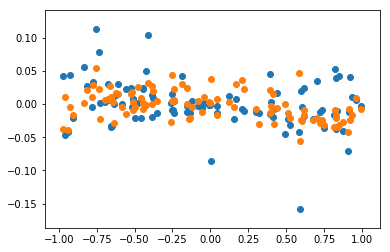

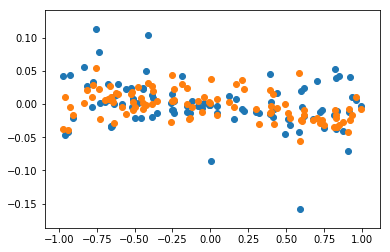

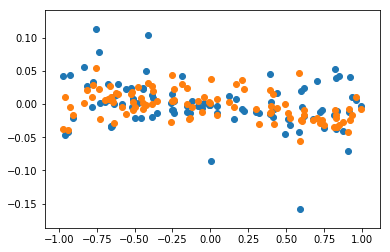

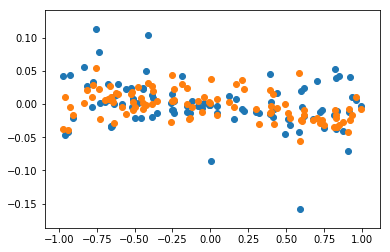

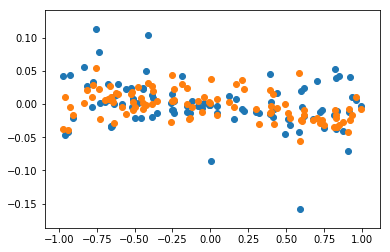

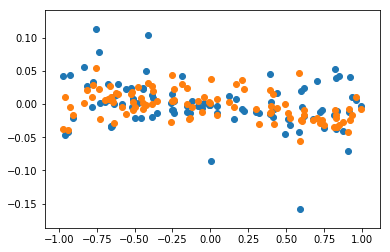

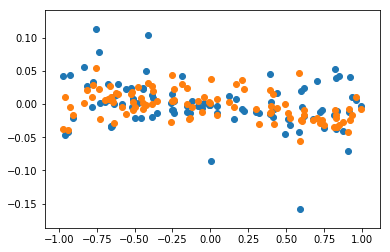

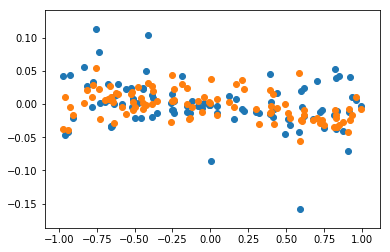

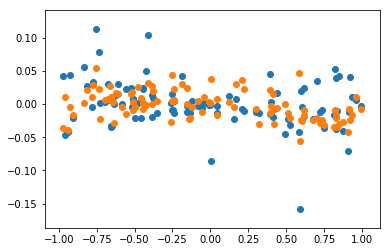

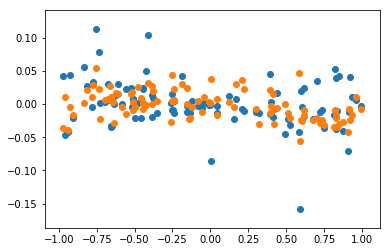

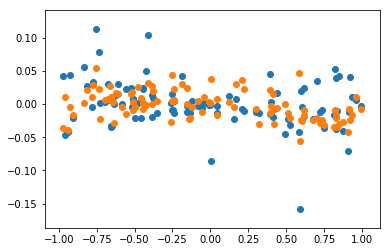

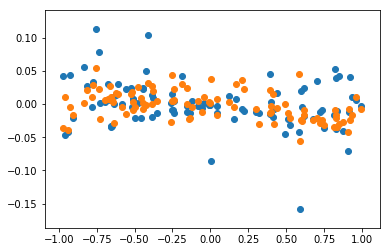

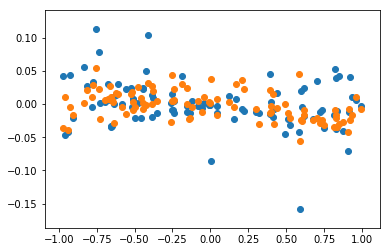

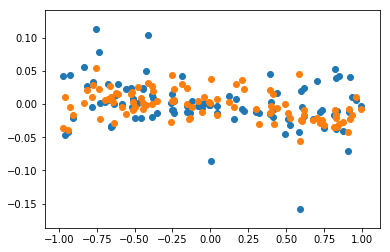

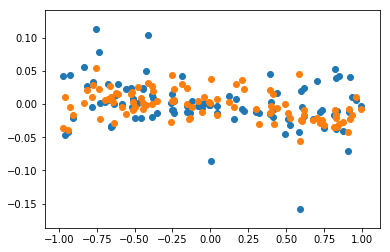

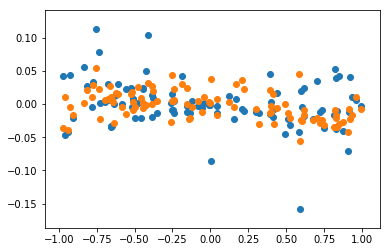

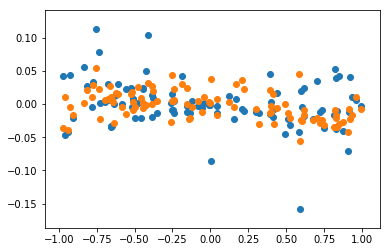

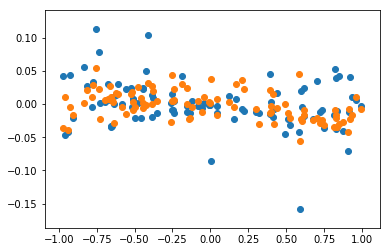

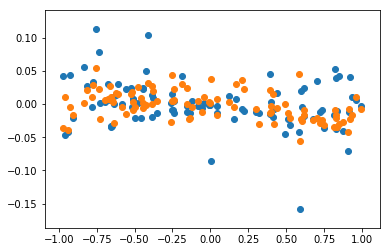

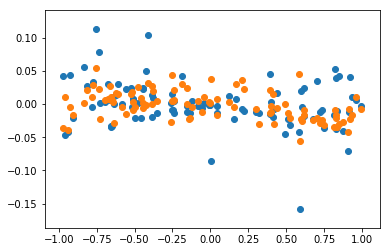

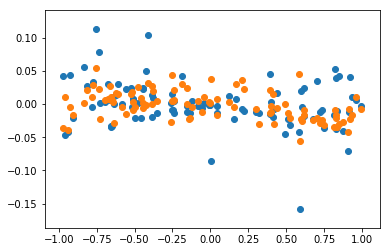

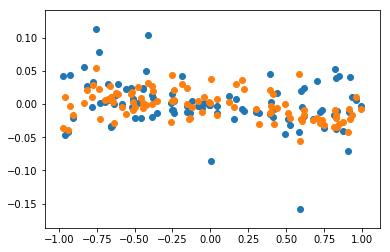

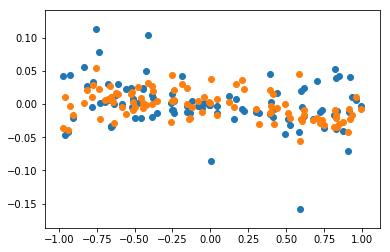

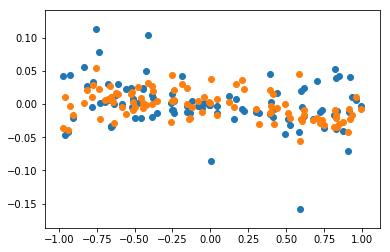

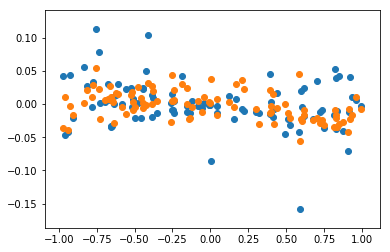

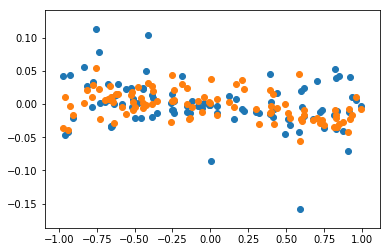

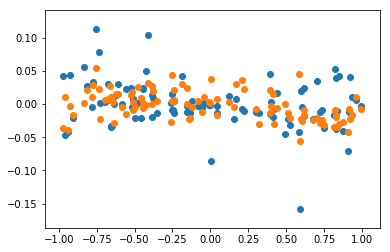

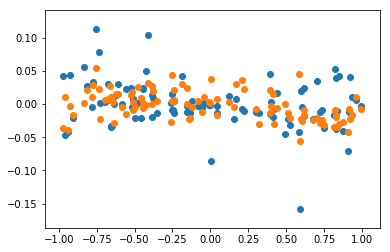

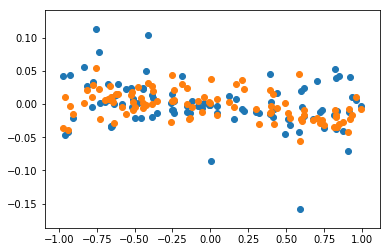

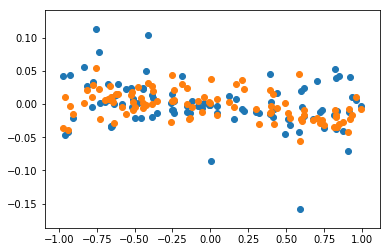

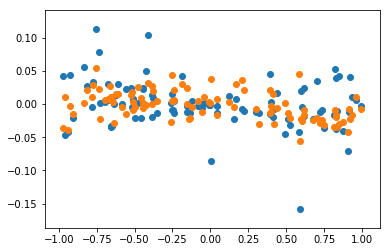

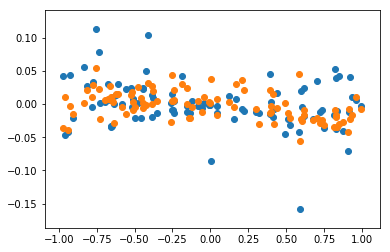

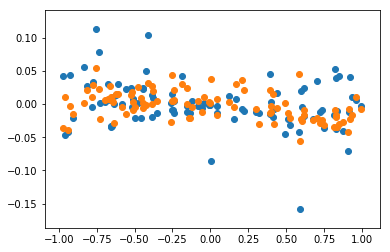

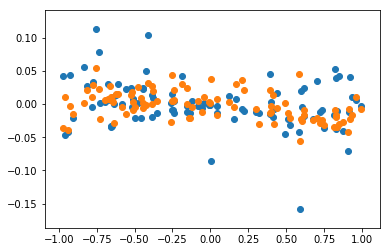

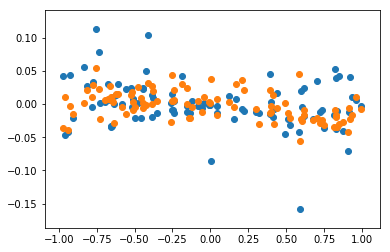

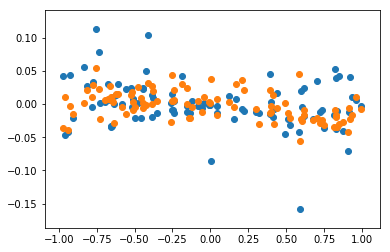

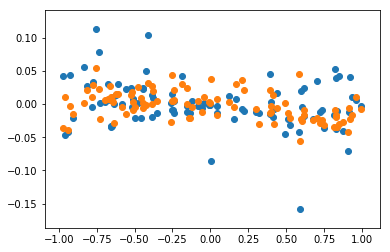

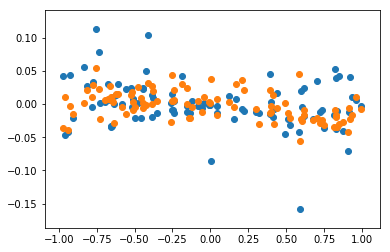

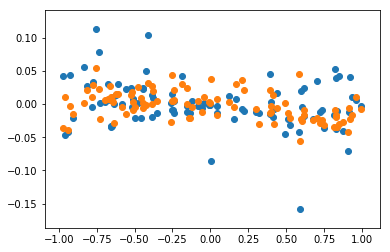

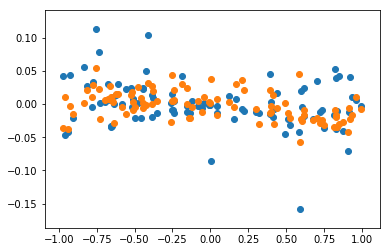

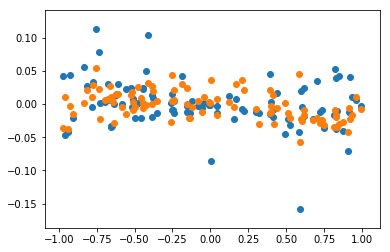

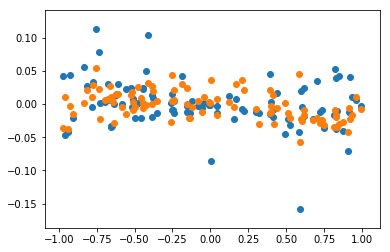

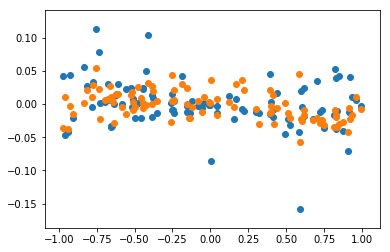

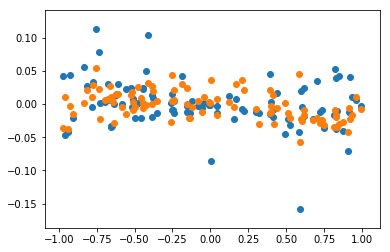

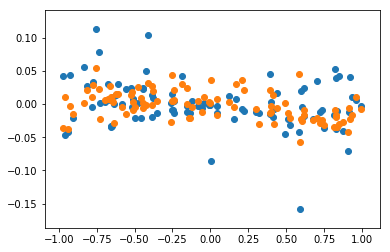

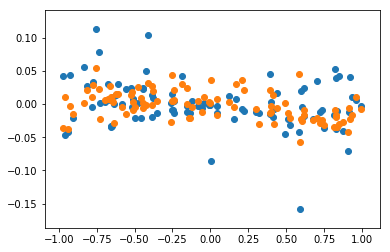

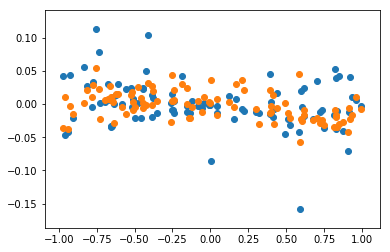

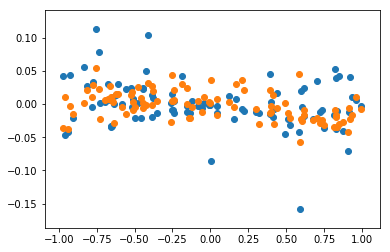

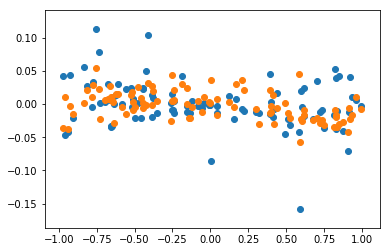

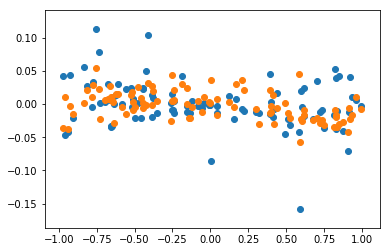

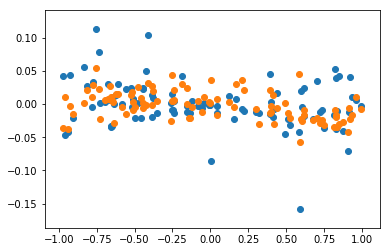

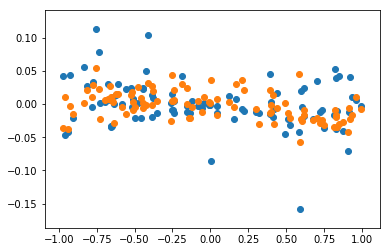

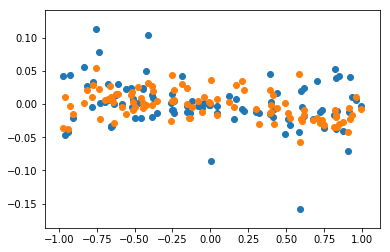

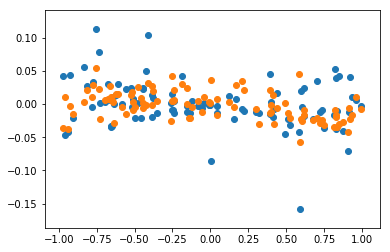

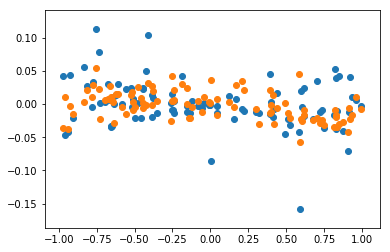

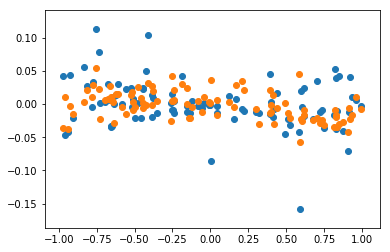

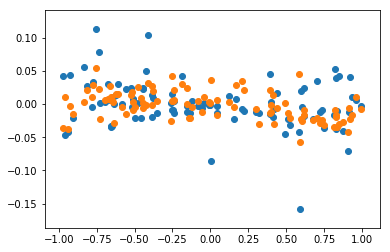

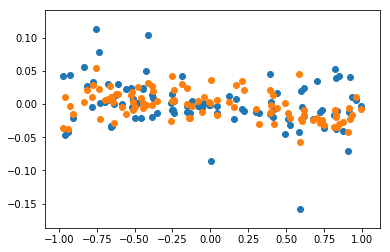

In [ ]:
optimizer = torch.optim.SGD(dynamics.parameters(), lr=0.2)
loss_func = torch.nn.MSELoss()

def train(model, data, epochs):
    zipped = Transition(*zip(*data))  # Transpose dataset
    states = torch.stack(zipped.state)
    actions = torch.stack(zipped.action)
    next_states = torch.stack(zipped.next_state)
    for epoch in range(epochs):
        predictions = model(states, actions)
        loss = loss_func(predictions, next_states)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % (epochs // 10):
            print("Loss [{}/{}]: {}".format(epoch+1, epochs, loss.data.numpy()))
            visualize(states, actions, next_states, predictions)
        plt.ioff()
        plt.show()
        
train(dynamics, data, 1000)

# Leverage model for planning

